In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from shapely.geometry import mapping, Polygon, Point, MultiPoint
from shapely.ops import unary_union
from shapely import overlaps, contains, contains_properly
from matplotlib.patches import Rectangle 
import matplotlib.gridspec as gridspec
from matplotlib.collections import PatchCollection
import matplotlib.axes as maxes
import glob
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable


import data_util as du
import comp_event_util as ceu
import grdc_util as grdcu

## Load GRDC data

grdc_no             river                         station     area  \
0   4115080.0     COWLITZ RIVER                 CASTLE ROCK, WA   5796.4   
1   4115081.0     COWLITZ RIVER          BELOW MAYFIELD DAM, WA   3626.0   
3   4115100.0  WILLAMETTE RIVER                       SALEM, OR  18855.2   
4   4115101.0  WILLAMETTE RIVER                    PORTLAND, OR  29008.0   
5   4115102.0  WILLAMETTE RIVER                  HARRISBURG, OR   8857.8   
..        ...               ...                             ...      ...   
41  4116451.0      OWYHEE RIVER                   NEAR ROME, OR  20720.0   
43  4116460.0       BOISE RIVER  GLENWOOD BRIDGE NEAR BOISE, ID   7252.0   
45  4116470.0       HENRYS FORK                NEAR REXBURG, ID   7562.8   
46  4116471.0       HENRYS FORK                 ST. ANTHONY, ID   4584.3   
49  4116480.0   BLACKFOOT RIVER              NEAR BLACKFOOT, ID   3354.1   

    altitude  lat_org  long_org   lat_pp   long_pp  dist_km  area_calc  \
0       6.16    46.29   -122.87  46.2771 -122.9146      0.3     5989.0   
1      69.07    46.54   -122.54  46.5104 -122.6146      0.1     3909.0   
3      32.35    44.87   -123.12  44.9438 -123.0438      0.1    18983.0   
4       0.47    45.46   -122.62  45.5187 -122.6688      0.1    28745.0   
5      87.90    44.12   -123.12  44.2687 -123.1729      0.2     9048.0   
..       ...      ...       ...      ...       ...      ...        ...   
41   1019.31    42.87   -117.62  42.8646 -117.6479      0.3    19873.0   
43    792.48    43.62   -116.21  43.6604 -116.2771      0.2     7092.0   
45   1464.98    43.87   -111.87  43.8271 -111.9021      0.3     8528.0   
46   1508.97    43.96   -111.62  43.9646 -111.6729      0.2     4804.0   
49   1347.22    43.21   -112.29  43.1312 -112.4688      0.0     4898.0   

   quality       type                                      comment  \
0     High  Automatic   Area difference <= 5% and distance <= 5 km   
1     High  Automatic   Area difference <= 5% and distance <= 5 km   
3     High  Automatic   Area difference <= 5% and distance <= 5 km   
4     High  Automatic   Area difference <= 5% and distance <= 5 km   
5     High  Automatic   Area difference <= 5% and distance <= 5 km   
..     ...        ...                                          ...   
41    High  Automatic   Area difference <= 5% and distance <= 5 km   
43    High  Automatic   Area difference <= 5% and distance <= 5 km   
45     Low  Automatic  Area difference 10-50% and distance <= 5 km   
46  Medium  Automatic   Area difference 5-10% and distance <= 5 km   
49     Low     Manual                    Not sure, but could be ok   

        source                                           geometry  
0   hydrosheds  POLYGON ((-121.58333 46.91667, -121.50000 46.9...  
1   hydrosheds  POLYGON ((-121.58333 46.91667, -121.50000 46.9...  
3   hydrosheds  POLYGON ((-123.41667 45.00000, -123.08333 45.0...  
4   hydrosheds  POLYGON ((-123.08333 45.83333, -123.00000 45.8...  
5   hydrosheds  POLYGON ((-122.08333 44.50000, -121.83333 44.5...  
..         ...                                                ...  
41  hydrosheds  POLYGON ((-117.41667 43.25000, -117.16667 43.2...  
43  hydrosheds  POLYGON ((-115.50000 44.08333, -115.41667 44.0...  
45  hydrosheds  POLYGON ((-111.50000 44.75000, -111.33333 44.7...  
46  hydrosheds  POLYGON ((-111.50000 44.75000, -111.33333 44.7...  
49  hydrosheds  POLYGON ((-111.83333 43.66667, -111.75000 43.6...  

[138 rows x 16 columns]

In [5]:
grdc_list = []
region_list = []
for region_name in [
    'COLUMBIA', 'GREAT_BASIN',  'NORTH_PACIFIC',  'SACRAMENTO',  'SAN_JOAQUIN',
    'KLAMATH', 'ROGUE', 'SALINAS', 'SKAGIT', 'SNAKE']:
    grdc, region = grdcu.load_grdc_data(region_name)
    grdc_list.append(grdc)
    region_list.append(region)
grdc = xr.concat(grdc_list, dim='id')
region = pd.concat(region_list)

# region_cmb_geometry = unary_union(region.geometry)
grdc, region = grdcu.constrain_grdc_data_to_5sec_calibrated(
    grdc, region, update_catchment_shape=False,
)
grdc

/home/Marc.Prange/work/AR-analysis/grdc_util.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  grdc_eval_5sec = pd.read_csv(


<xarray.Dataset>
Dimensions:              (time: 53211, id: 138)
Coordinates:
  * time                 (time) datetime64[ns] 1878-06-01 ... 2024-02-06
  * id                   (id) int32 4115080 4115081 4115100 ... 4116471 4116480
Data variables:
    runoff_mean          (time, id) float32 nan nan nan nan ... nan nan nan nan
    area                 (id) float32 5.989e+03 3.909e+03 ... 4.898e+03
    country              (id) object 'US' 'US' 'US' 'US' ... 'US' 'US' 'US' 'US'
    geo_x                (id) float32 -122.9 -122.5 -123.1 ... -111.6 -112.3
    geo_y                (id) float32 46.29 46.54 44.87 ... 43.87 43.96 43.21
    geo_z                (id) float32 6.16 69.07 32.35 ... 1.509e+03 1.347e+03
    owneroforiginaldata  (id) object 'United States of America - US Geologica...
    river_name           (id) object 'COWLITZ RIVER' ... 'BLACKFOOT RIVER'
    station_name         (id) object 'CASTLE ROCK, WA' ... 'NEAR BLACKFOOT, ID'
    timezone             (id) float32 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    dsch                 (time, id) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 03/04/2024
    missing_value:  -999.000

In [23]:
for river in region.river:
    print(river)

COLUMBIA RIVER
COLUMBIA RIVER
SNAKE RIVER
COLUMBIA RIVER
SNAKE RIVER
COLUMBIA RIVER
COLUMBIA RIVER
SNAKE RIVER
SNAKE RIVER
COLUMBIA RIVER
SNAKE RIVER
SNAKE RIVER
SNAKE RIVER
COLUMBIA RIVER
PEND OREILLE RIVER
CLARK FORK
SACRAMENTO RIVER
CLARK FORK
SNAKE RIVER
HUMBOLDT RIVER
KOOTENAI RIVER
SNAKE RIVER
SALMON RIVER
SAN JOAQUIN RIVER
KOOTENAI RIVER
KLAMATH RIVER
WILLAMETTE RIVER
OWYHEE RIVER
CLARK FORK
DESCHUTES RIVER
KOOTENAI RIVER
SNAKE RIVER
CLEARWATER RIVER
CLARK FORK
FLATHEAD RIVER
OKANOGAN RIVER
OWYHEE RIVER
DESCHUTES RIVER
JOHN DAY RIVER
WILLAMETTE RIVER
OKANOGAN RIVER
FLATHEAD RIVER
KLAMATH RIVER
SALMON RIVER
SPOKANE RIVER
CLARK FORK
YAKIMA RIVER
CLEARWATER RIVER
SNAKE RIVER
JOHN DAY RIVER
HUMBOLDT RIVER
CRAB CREEK
KOOTENAI RIVER
CROOKED RIVER
SPOKANE RIVER
SALINAS RIVER
ROGUE RIVER
KLAMATH RIVER
SPOKANE RIVER
KETTLE RIVER
KETTLE RIVER
SALMON RIVER
COLUMBIA RIVER
UMPQUA RIVER
SIMILKAMEEN RIVER
YAKIMA RIVER
WILLAMETTE RIVER
PAYETTE RIVER
OKANOGAN RIVER
SKAGIT RIVER
AMARGOSA RIVER
WI

In [25]:


region = region.sort_values('area', ascending=False)
region.loc[region[region['river'] == 'SACRAMENTO RIVER'].index[0], :]

river                                         SACRAMENTO RIVER
station                                             VERONA, CA
area                                                   55040.1
altitude                                                 -0.91
lat_org                                                  38.79
long_org                                               -121.62
lat_pp                                                 38.7729
long_pp                                              -121.5979
dist_km                                                    0.2
area_calc                                              56742.0
quality                                                   High
type                                                 Automatic
comment             Area difference <= 5% and distance <= 5 km
source                                              hydrosheds
geometry     POLYGON ((-120.4792 42.4292, -120.45 42.4292, ...
Name: 4146281.0, dtype: object

In [ ]:
path_to_eval_data='/archive/Marc.Prange/cama-flood/'
grdc_alloc = pd.read_csv(
        path_to_eval_data+'GRDC_alloc_5min_lat_lon_area_cal.txt',
        header=0, index_col=0, sep='\s+')
grdc_alloc

lat     lon  area_Input  area_CaMa  error    diff  Type  ix1  iy1  \
ID                                                                              
4113300  47.929 -97.029    66126.98   66136.41   0.00    9.43     0  331   71   
4113301  48.571 -97.146    77963.33   78360.49   0.01  397.16     0  329   65   
4113302  47.354 -96.846    42043.52   42113.49   0.00   69.97     0  332   77   
4113303  46.862 -96.779    17313.17   17390.98   0.00   77.81     0  333   82   
4113304  46.662 -96.796    10861.79   10862.57   0.00    0.78     0  333   85   
...         ...     ...         ...        ...    ...     ...   ...  ...  ...   
4358510  21.171 -98.279     1258.06    1176.66  -0.06  -81.39     2  317  340   
4358520  21.037 -98.154     1500.10    1500.75   0.00    0.65     0  318  340   
4358550  20.929 -97.662     4334.14    4527.54   0.04  193.41     0  323  342   
4358600  20.546 -97.462     1576.07    1488.60  -0.06  -87.48     1  325  346   
4358800  20.062 -97.029     1445.63    1445.21  -0.00   -0.42     0  329  350   

         ix2  iy2    area1  area2  
ID                                 
4113300 -999 -999  66136.4 -999.0  
4113301 -999 -999  78360.5 -999.0  
4113302 -999 -999  42113.5 -999.0  
4113303 -999 -999  17391.0 -999.0  
4113304 -999 -999  10862.6 -999.0  
...      ...  ...      ...    ...  
4358510  316  340   1011.9  164.8  
4358520 -999 -999   1500.8 -999.0  
4358550 -999 -999   4527.5 -999.0  
4358600 -999 -999   1488.6 -999.0  
4358800 -999 -999   1445.2 -999.0  

[1592 rows x 13 columns]

In [ ]:
grdc_eval_5sec = pd.read_csv(
        path_to_eval_data+'evaluation_csv/GRDC_station_select_for_5min.csv', usecols=np.arange(18, 32), 
        header=2, skipfooter=6414-3916, index_col=0)

new_cols = ['latGRDC.1', 'lonGRDC.1', 'areaGRDC.1']
exclude_cols = [col for col in grdc_eval_5sec.columns if col not in new_cols]
grdc_eval_5sec.drop(exclude_cols, axis=1)[new_cols].to_csv(path_to_eval_data+'grdc_5sec_cal_original_lat_lon_area.csv')

/tmp/ipykernel_142234/2441911477.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  grdc_eval_5sec = pd.read_csv(


## Load AM4/LM4.0 data

In [ ]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/'
           'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020_na_*.nc') 
 if int(p[-7:-3]) in range(1980, 2020)]
model_data = xr.open_mfdataset(paths).load()
model_river_static = du.sel_na(du.lon_360_to_180(xr.open_dataset(
    '/archive/Ming.Zhao/awg/2022.03/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/gfdl.ncrc4-intel-prod-openmp/pp/river/'
    'river.static.nc')))
model_data['vol_discharge'] = (
    model_data.rv_o_h2o + model_data.rv_d_h2o) * model_river_static.land_area / 1000
model_data['vol_discharge_o'] = (
    model_data.rv_o_h2o) * model_river_static.land_area / 1000
model_data['vol_discharge_d'] = (
    model_data.rv_d_h2o) * model_river_static.land_area / 1000
model_data['vol_runoff'] = model_data.mrro * model_river_static.land_area / 1000

## Load atm. obs data (IVT, AR shape, Precip)

In [ ]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/c192_obs/'
           'c192_obs_na_*.nc')
 if int(p[-7:-3]) in range(1980, 2020)]
era5_data = xr.open_mfdataset(paths).load()

## 0.1° MSWEP data

In [6]:
paths = [p for p in 
 glob.glob('/archive/Marc.Prange/na_data/mswep_0p1deg_daily/'
           'MSWEPV2_*.0.1_daily_na.nc')
 if int(p[-20:-16]) in range(1980, 2020)]
mswep_data = xr.open_mfdataset(paths).load()
mswep_data

<xarray.Dataset>
Dimensions:    (time: 14610, bnds: 2, lon: 800, lat: 500)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T10:30:00 ... 2019-12-31T10:30:00
  * lon        (lon) float32 -139.9 -139.8 -139.8 ... -60.25 -60.15 -60.05
  * lat        (lat) float32 20.05 20.15 20.25 20.35 ... 69.65 69.75 69.85 69.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1980-01-01 ... 2019-12-31T21:00:00
    precip     (time, lat, lon) float32 0.1094 0.08594 ... 0.03906 0.03906
Attributes:
    CDI:            Climate Data Interface version 2.1.1 (https://mpimet.mpg....
    Conventions:    CF-1.0
    contact:        Wenhao.Dong (Wenhao.Dong@NOAA.gov)
    creation_date:  Tue Mar  7 13:43:00 EST 2023
    NCL:            6.6.2
    title:          Save MSWEPV2 3hr dataset on 0.1 degree; data_preprocess/s...
    frequency:      day
    history:        Wed May 29 16:21:28 2024: cdo -sellonlatbox,-140,-60,20,7...
    CDO:            Climate Data Operators version 2.1.1 (https://mpimet.mpg....

## Load cama-flood data (10 km discharge, floodplain, etc.)

In [ ]:
paths = [p for p in
         glob.glob(
             '/archive/Marc.Prange/cama-flood/'
             'LM4-conus_06min_1951_2020/o_outflw*.nc')]
print("Reading CaMa-Flood data...")
cama_data = xr.open_mfdataset(paths).load()
print("Reversing order of latitude coordinate...")
cama_data_reverse_lat = cama_data.reindex(lat=list(reversed(cama_data.lat)))
cama_data

Reading CaMa-Flood data...
Reversing order of latitude coordinate...


<xarray.Dataset>
Dimensions:  (lat: 350, lon: 700, time: 10227)
Coordinates:
  * lat      (lat) float32 54.95 54.85 54.75 54.65 ... 20.35 20.25 20.15 20.05
  * lon      (lon) float32 -129.9 -129.9 -129.8 -129.6 ... -60.25 -60.15 -60.05
  * time     (time) datetime64[ns] 1980-01-02 1980-01-03 ... 2008-01-01
Data variables:
    outflw   (time, lat, lon) float32 0.0105 0.01489 10.65 9.787 ... nan nan nan

## Load cama-flood p2K data (10 km discharge, floodplain, etc.)

In [ ]:
paths = [p for p in
         glob.glob(
             '/archive/Marc.Prange/cama-flood/'
             'LM4-conus_06min_1day_p2K/o_outflw*.nc')]
print("Reading CaMa-Flood data...")
cama_data_p2K = xr.open_mfdataset(paths).load()
print("Reversing order of latitude coordinate...")
cama_data_reverse_lat = cama_data.reindex(lat=list(reversed(cama_data.lat)))
cama_data

In [7]:
model_basin_mask = grdcu.model_basin_mask(model_data, region_cmb_geometry)
cama_basin_mask = grdcu.model_basin_mask(cama_data, region_cmb_geometry)

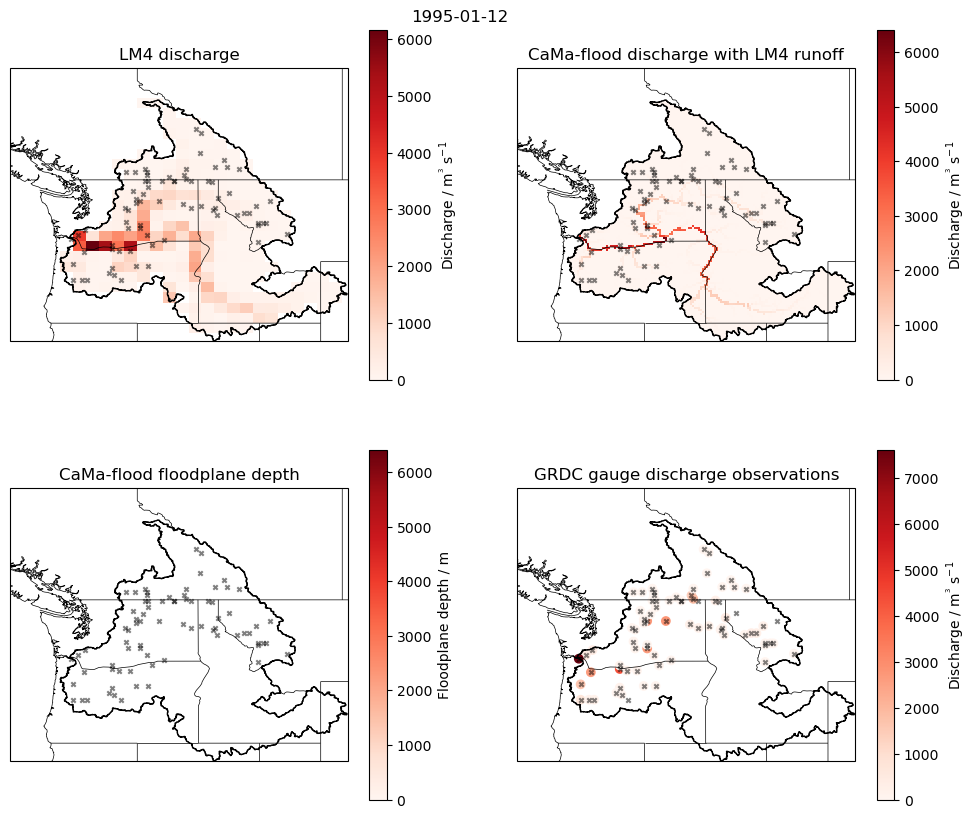

In [17]:
day = '1995-01-12'
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
pc = ax1.pcolormesh(
    model_data.lon, model_data.lat, 
    model_data.vol_discharge_o.sel(time=day).where(model_basin_mask),
    cmap='Reds', vmin=0, #vmax=6000,
    )
fig.colorbar(pc, label='Discharge / m$^{^3}$ s$^{-1}$')
ax1.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
xx, yy = region_cmb_geometry.exterior.coords.xy
ax1.plot(xx, yy, color='black', lw=1, label='catchment')
ax1.set(title='LM4 discharge')

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
s = ax2.pcolormesh(
    cama_data.lon, cama_data.lat,
    cama_data.outflw.sel(time=day).where(cama_basin_mask),
    cmap='Reds', vmin=0, #vmax=3700,
    )
ax2.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
ax2.plot(xx, yy, color='black', lw=1, label='catchment')
fig.colorbar(s, label='Discharge / m$^{^3}$ s$^{-1}$')
ax2.set(title='CaMa-flood discharge with LM4 runoff')

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
# s = ax3.pcolormesh(
#     cama_data.lon, cama_data.lat,
#     cama_data.flddph.sel(time=day).where(cama_basin_mask),
#     cmap='Reds', vmin=0, vmax=5
#     )
ax3.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
ax3.plot(xx, yy, color='black', lw=1, label='catchment')
fig.colorbar(s, label='Floodplane depth / m', ax=ax3)
ax3.set(title='CaMa-flood floodplane depth')

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
s = ax4.scatter(
    grdc.geo_x, grdc.geo_y,
    c=grdc.runoff_mean.sel(time=day),
    cmap='Reds', marker='o', vmin=0, #vmax=7000,
    )
ax4.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
fig.colorbar(s, label='Discharge / m$^{^3}$ s$^{-1}$')
ax4.plot(xx, yy, color='black', lw=1, label='catchment')
ax4.set(title='GRDC gauge discharge observations')

plt.suptitle(f'{day}', y=0.9)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_extent(
        [region.long_org.min()-3, region.long_org.max()+3, 
         region.lat_org.min()-3, region.lat_org.max()+3], 
        crs=ccrs.PlateCarree())
    ax.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

## Discharge timeseries of individual catchments

0	COWLITZ RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


1	COWLITZ RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


3	WILLAMETTE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


4	WILLAMETTE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


5	WILLAMETTE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


6	MCKENZIE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


7	MCKENZIE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


8	COLUMBIA RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


9	COLUMBIA RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


10	COLUMBIA RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


13	COLUMBIA RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


14	COLUMBIA RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


15	KLICKITAT RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


17	JOHN DAY RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


18	JOHN DAY RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


20	NORTH FORK JOHN DAY RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


22	CROOKED RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


23	CROOKED RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


24	WENATCHEE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


25	WENATCHEE RIVER


/tmp/ipykernel_13562/2477071056.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


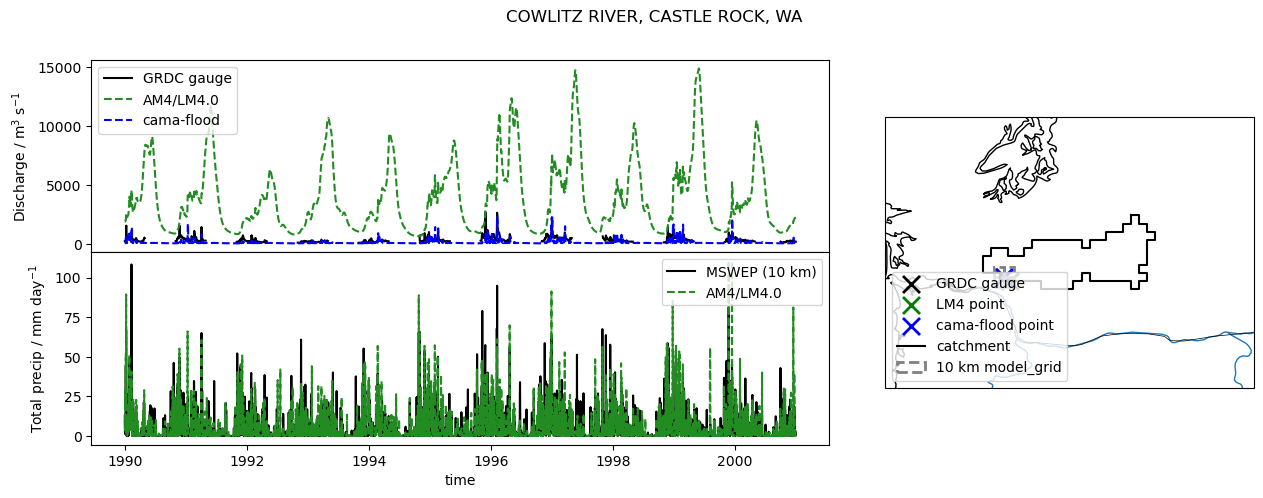

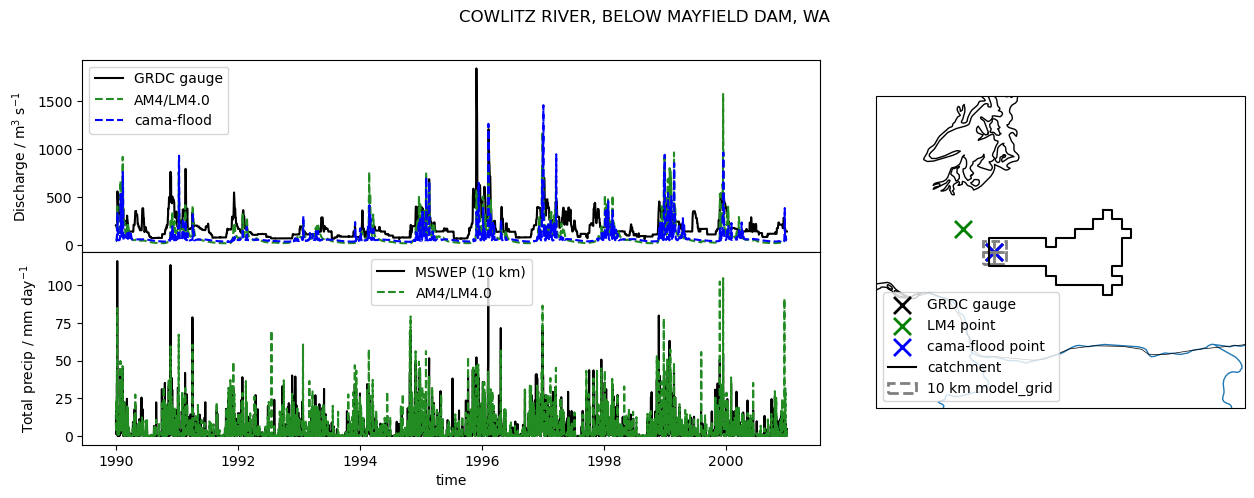

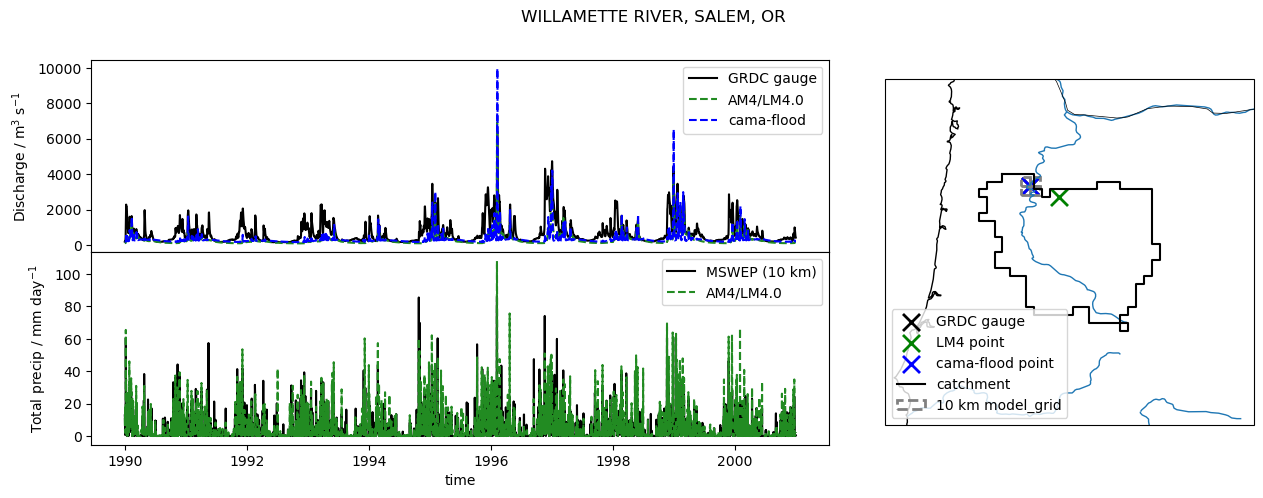

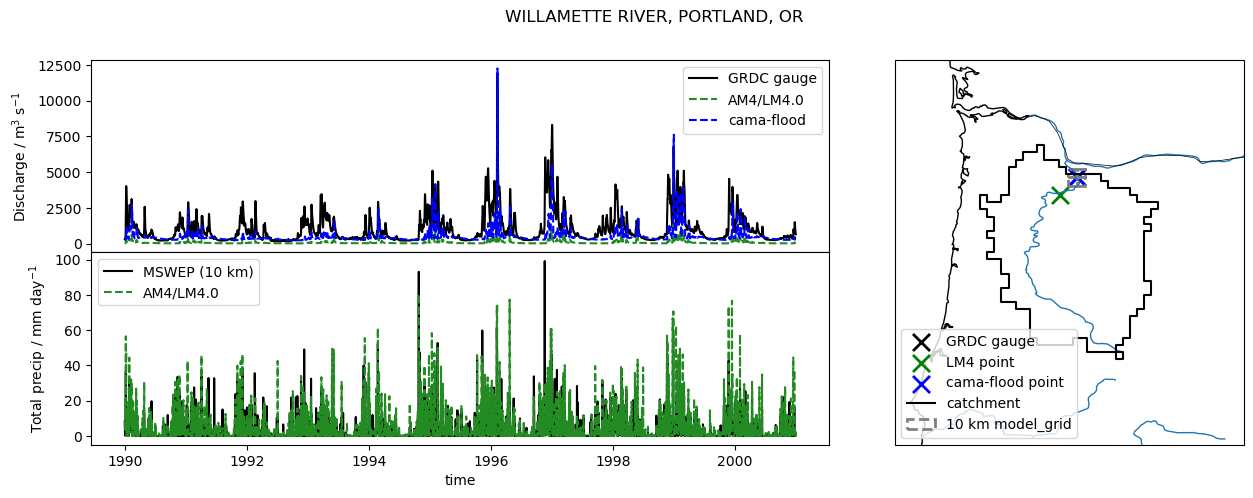

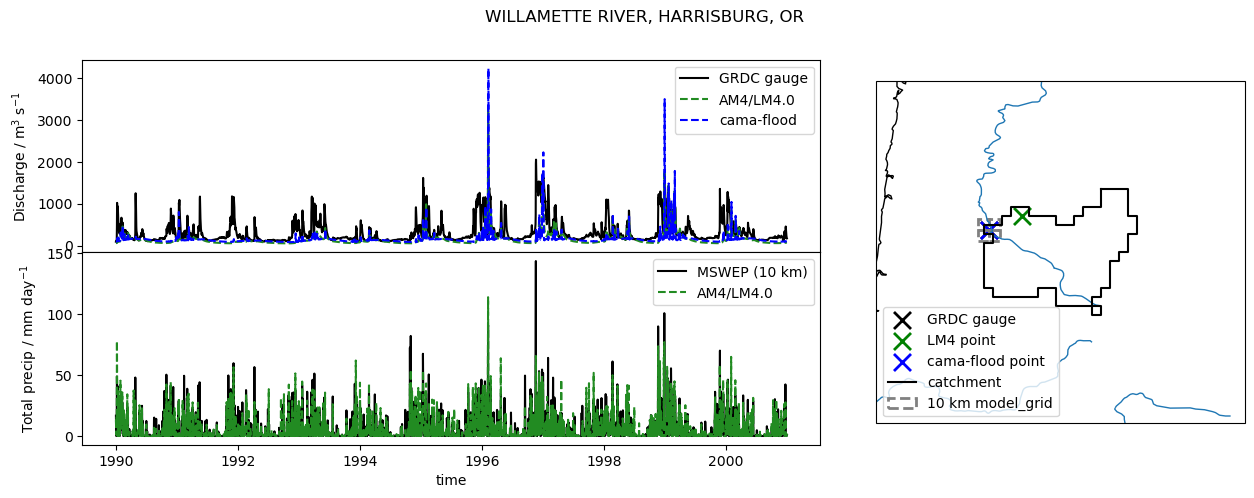

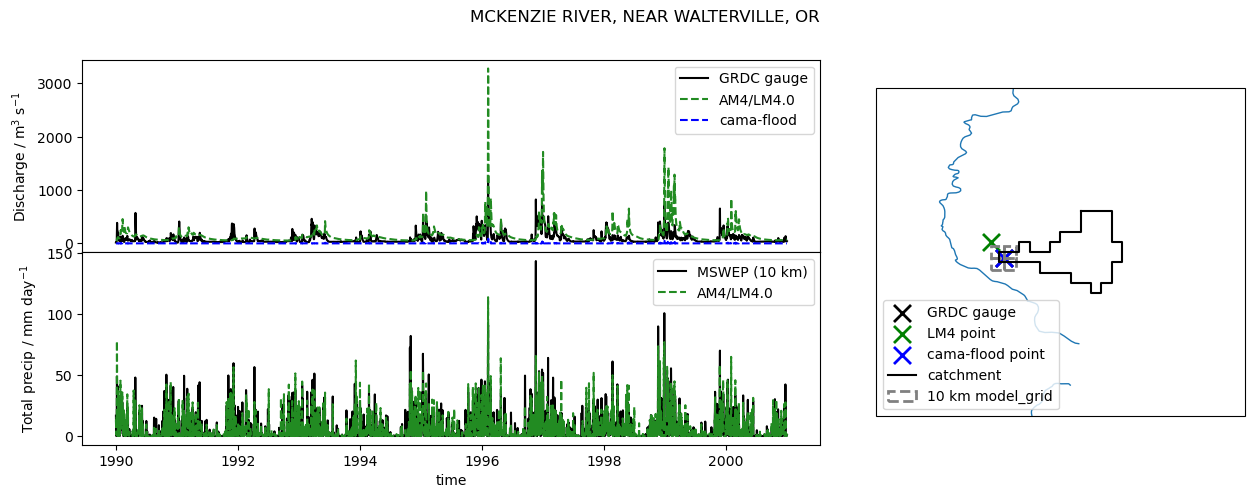

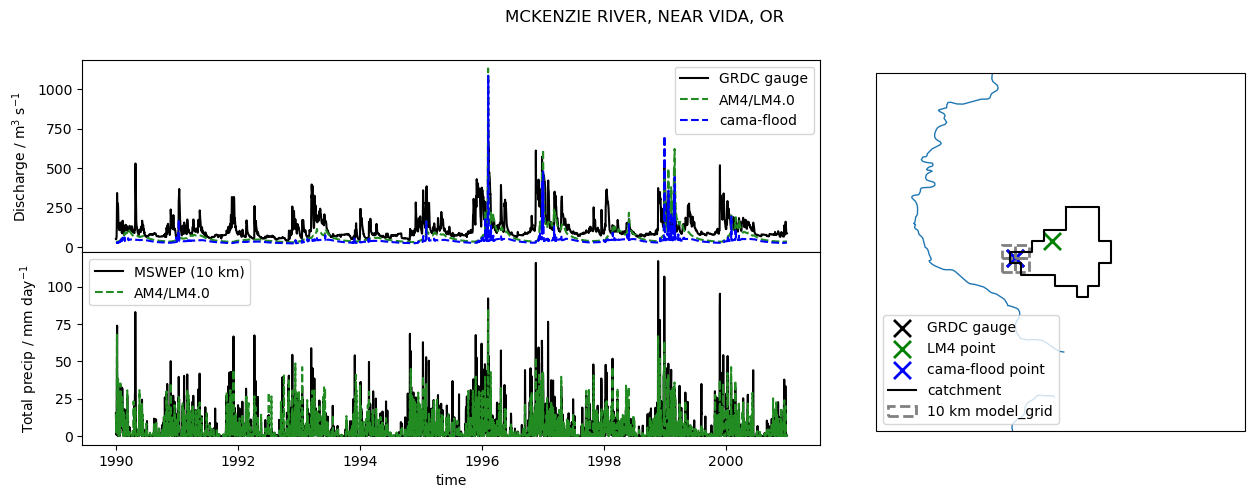

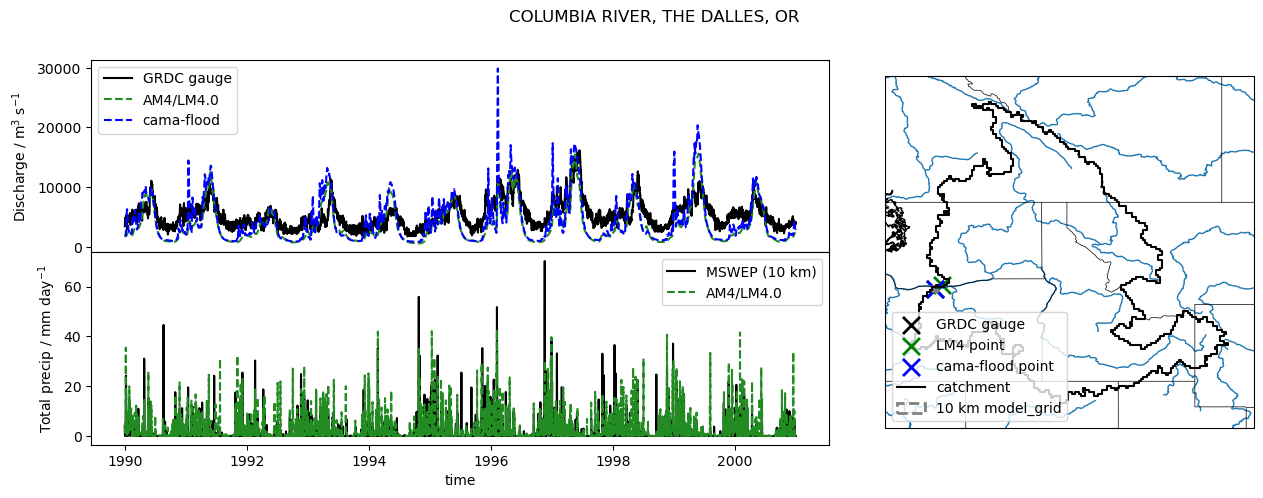

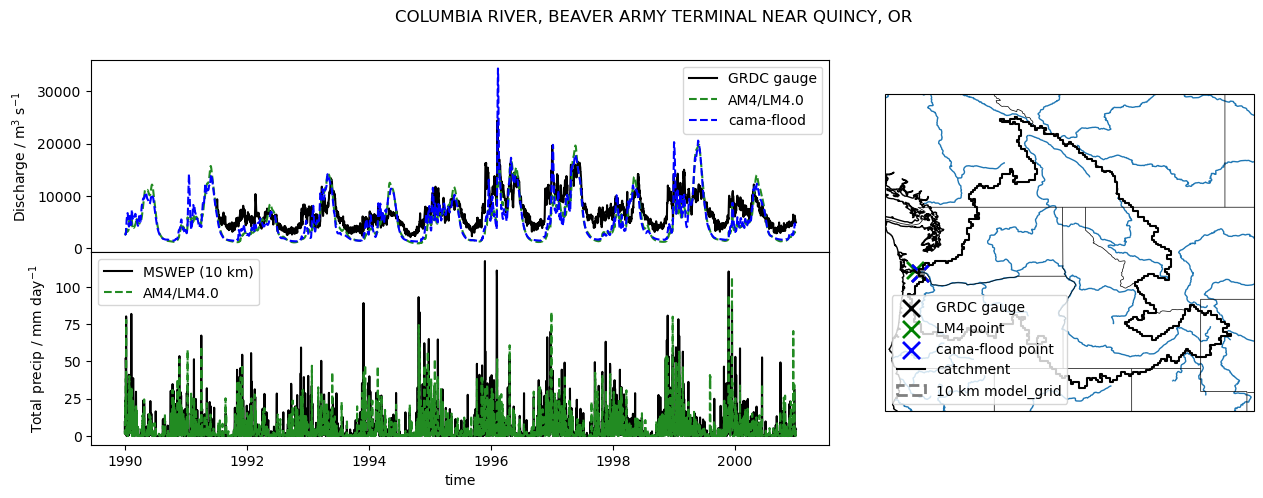

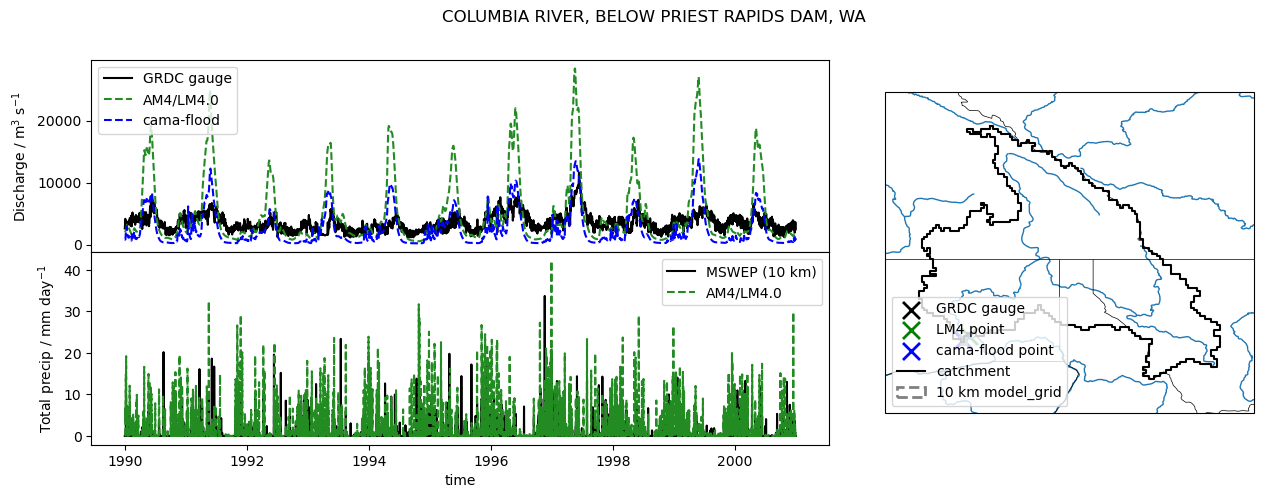

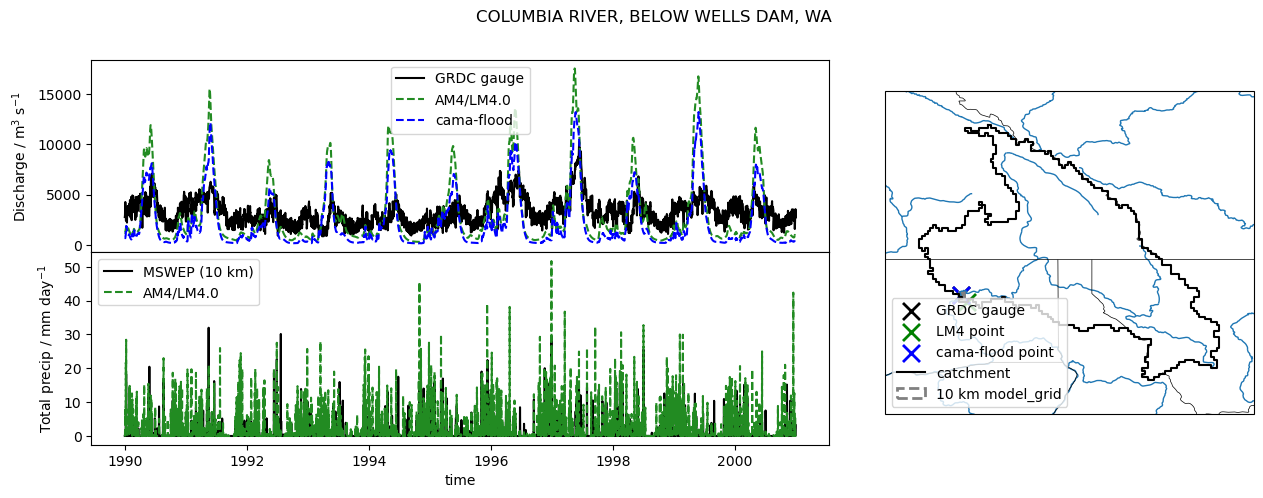

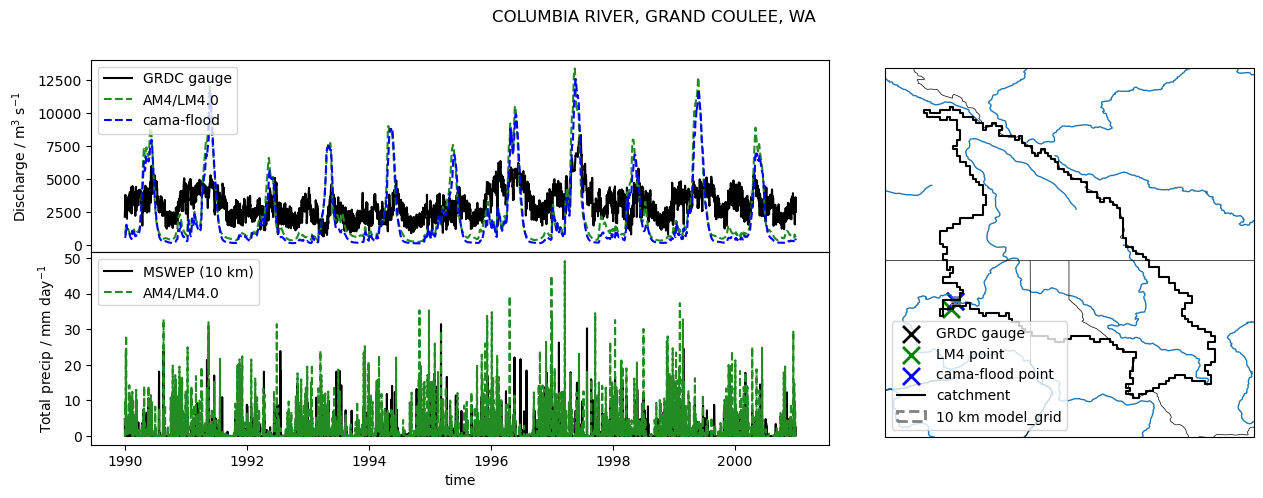

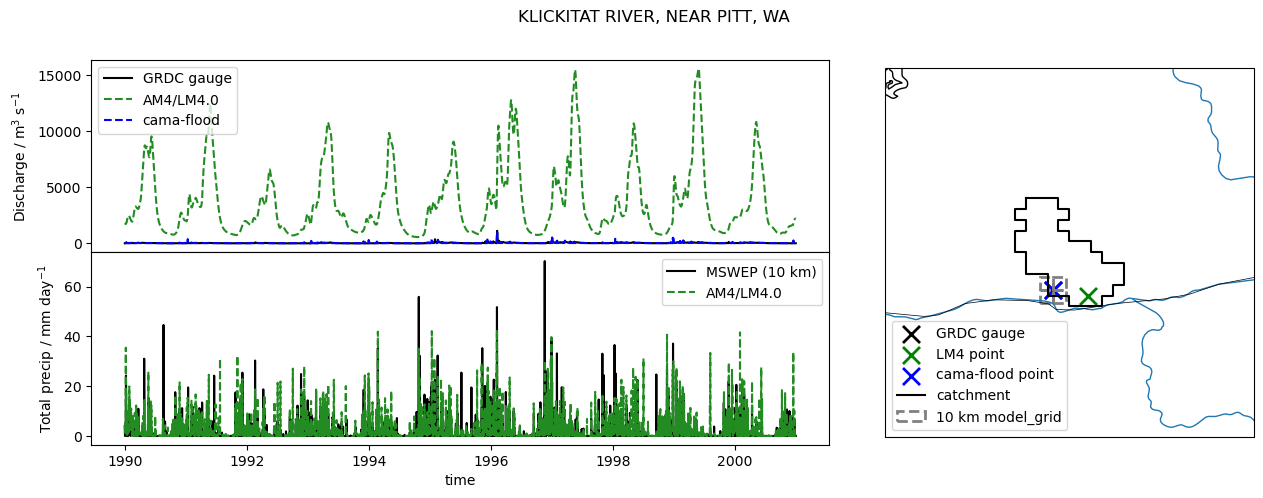

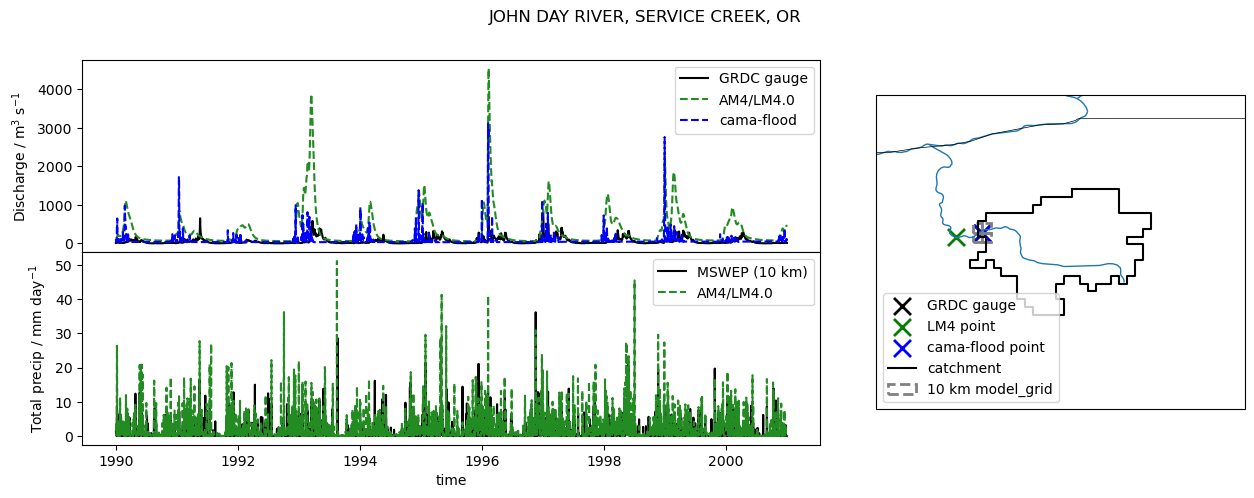

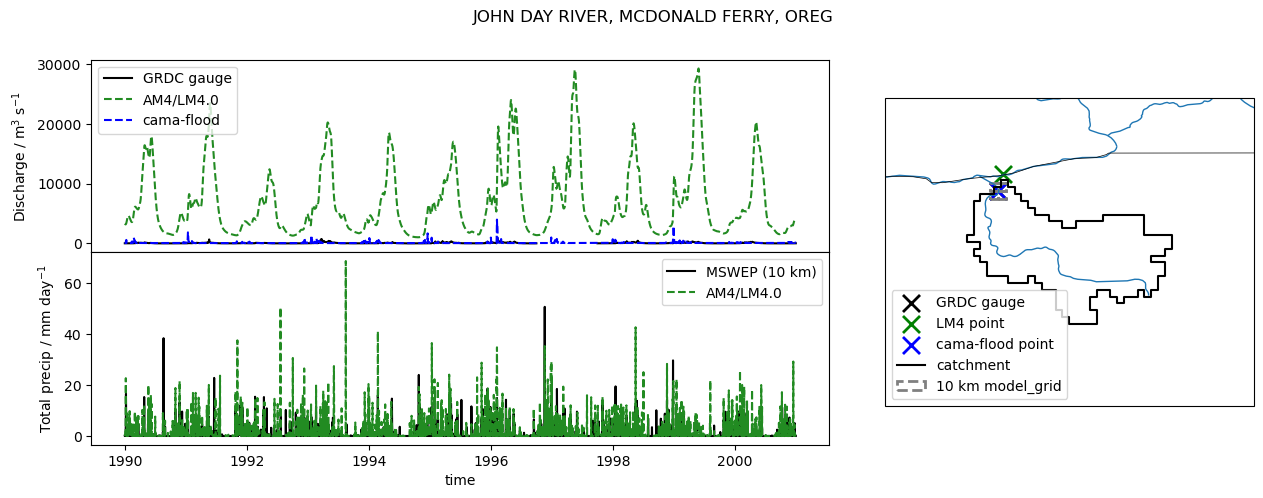

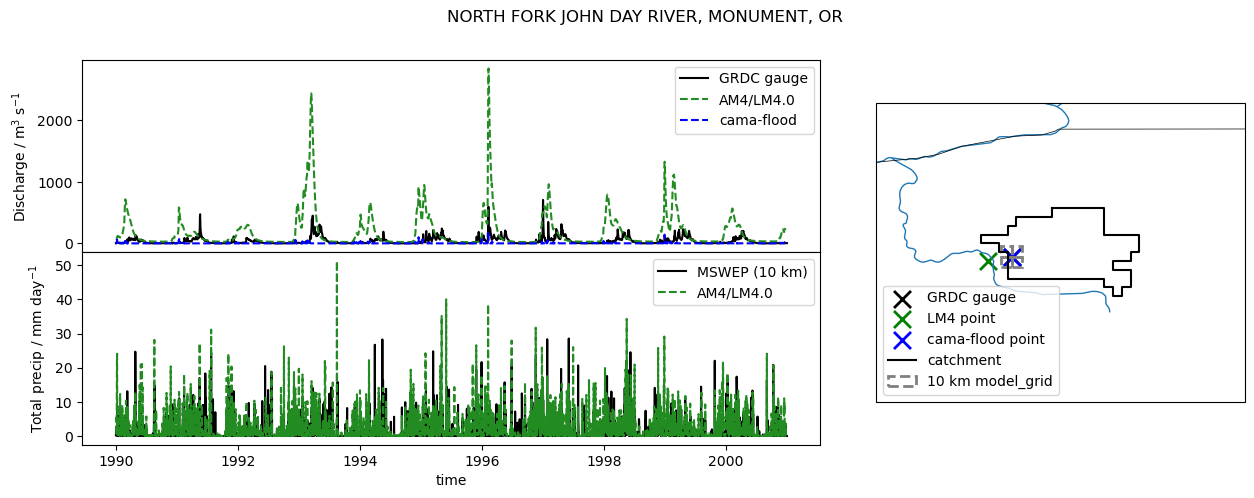

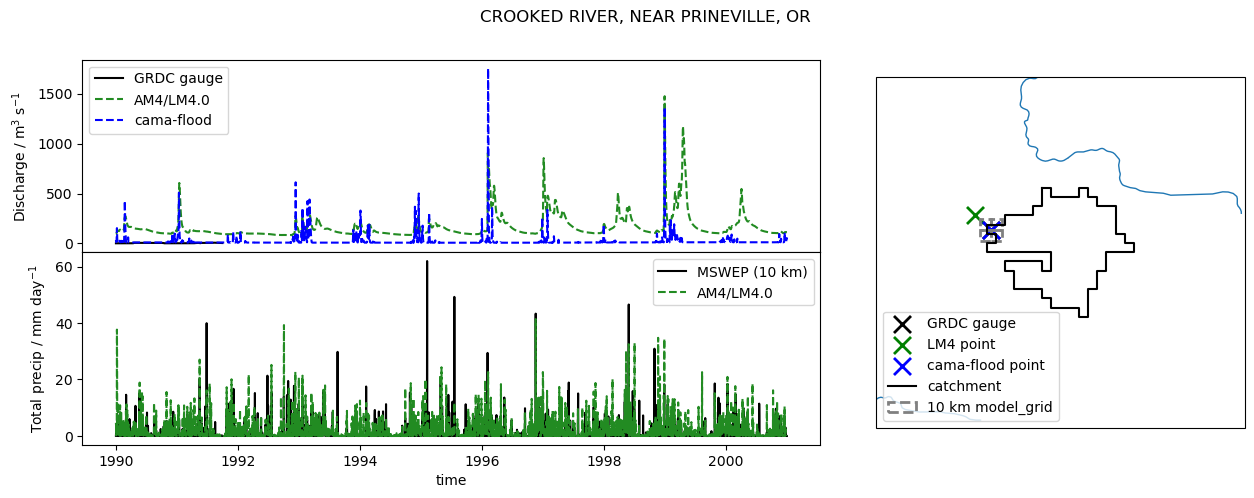

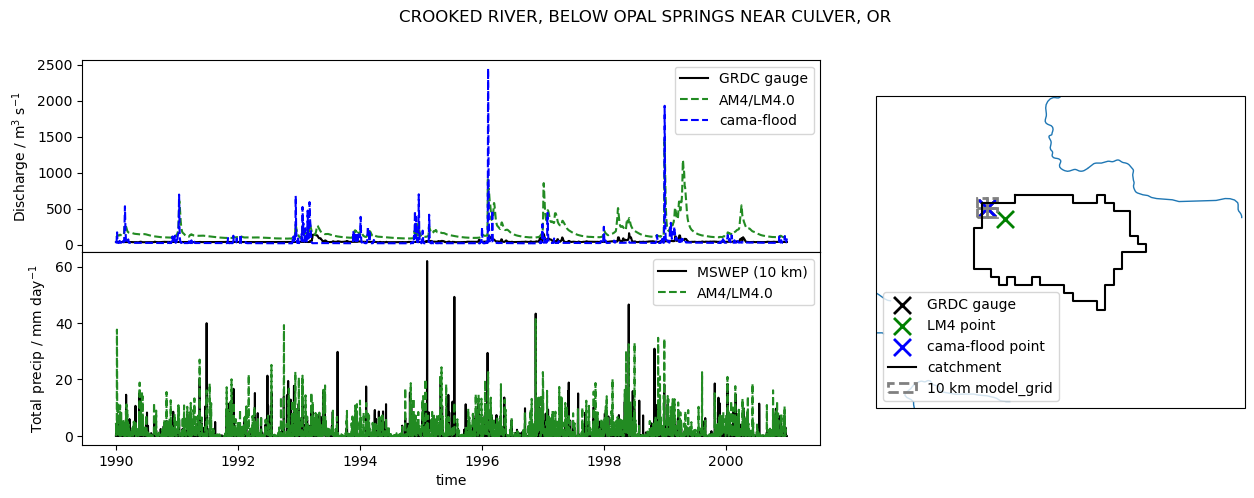

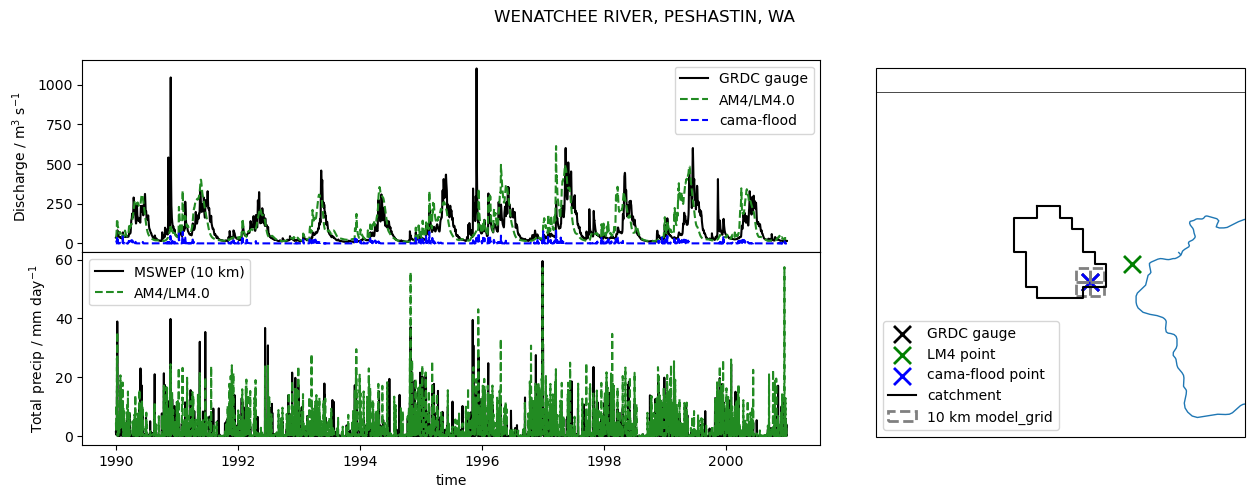

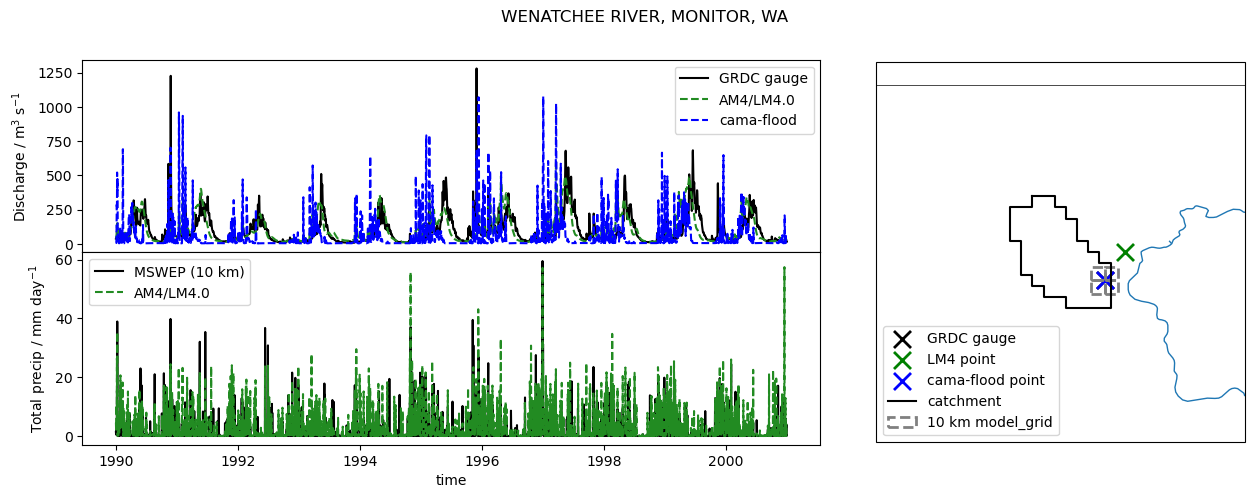

In [11]:
# model_time_mask = np.isin(model_data.time, cama_data.time)
# obs_time_mask = np.isin(grdc.time, cama_data.time)
for i, basin in list(region.iterrows())[:20]:
    print(f"{i}\t{basin.river}")
    grdc_basin = grdc.sel(id=basin.grdc_no)
    basin_scale = np.sqrt(grdc_basin.area.values)
    # if (basin_scale < 100):
    #     print(f"Basin scale too small (~{np.round(basin_scale, 2)} km) for comparison to model.")
    #     continue
    # elif (basin_scale > 500): 
    #     print(f"Basin scale too large (~{np.round(basin_scale, 2)} km) for now...")
    #     continue
    # model_basin_mask = xr.DataArray(
    #     data=np.array([[basin.geometry.contains(Point(lon, lat)) 
    #                     for lon in model_data.lon] 
    #                 for lat in model_data.lat]).squeeze(),
    #     coords=(model_data.lat, model_data.lon)
    #     )

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(
        nrows=2, ncols=2, width_ratios=[2, 1], hspace=0.001, wspace=0.1)
    ax1 = fig.add_subplot(gs[0, 0])

    model_dsch = model_data.sel(time=slice('1990', '2000')).vol_discharge#.where(model_basin_mask).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    obs_dsch = grdc_basin.sel(time=slice('1990', '2000')).runoff_mean
    cama_dsch = cama_data.sel(time=slice('1990', '2000')).outflw
    model_precip = model_data.sel(time=slice('1990', '2000')).pr#.where(model_basin_mask).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
    obs_precip = era5_data.sel(time=slice('1990', '2000')).pr
    nearest_model_lat, nearest_model_lon = grdcu.find_nearest_point(
        model_data.lat.values, model_data.lon.values, basin.lat_org, basin.long_org)
    # nearest_cama_lat, nearest_cama_lon = grdcu.find_nearest_point(
    #     cama_data.lat.values, cama_data.lon.values, basin.lat_org, basin.long_org)
    model_dsch = grdcu.interp_model_point_to_gauge(model_dsch, basin.lat_org, basin.long_org, method='nearest')
    basin_gauge_in_cama_alloc = np.isin(grdc_alloc.index, int(basin.grdc_no))
    # if not basin_gauge_in_cama_alloc.any():
    #     print("Basin Gauge could not be allocated to CaMa-Flood pixel. Continuing...")
    #     continue
    # cama_dsch = grdcu.get_closest_cama_point_to_gauge(cama_dsch, grdc_alloc.loc[basin_gauge_in_cama_alloc])
    cama_dsch = grdcu.interp_model_point_to_gauge(cama_dsch, basin.lat_org, basin.long_org, method='nearest')
    nearest_cama_lat = cama_dsch.lat.values
    nearest_cama_lon = cama_dsch.lon.values
    # cama_dsch = cama_dsch.sum(['lat', 'lon'])
    model_precip = grdcu.interp_model_point_to_gauge(model_precip, basin.lat_org, basin.long_org, method='nearest')
    obs_precip = grdcu.interp_model_point_to_gauge(obs_precip, basin.lat_org, basin.long_org, method='nearest')
    
    ax1.plot(
        obs_dsch.time, 
        obs_dsch, 
        color='black', label='GRDC gauge')
    ax1.plot(
        model_dsch.time,
        model_dsch,
        color='forestgreen', ls='--', label='AM4/LM4.0')
    ax1.plot(
        cama_dsch.time,
        cama_dsch,
        color='blue', ls='--', label='cama-flood')
    
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(
        obs_precip.time, 
        obs_precip*86400, 
        color='black', label='MSWEP (10 km)')
    ax2.plot(
        model_precip.time,
        model_precip*86400,
        color='forestgreen', ls='--', label='AM4/LM4.0')
    
    ax3 = fig.add_subplot(gs[:, 1], projection=ccrs.PlateCarree())

    s3 = ax3.scatter(
        basin.long_org, basin.lat_org,
        color='black', marker='x', s=150, label='GRDC gauge', lw=2,
    )
    # cor_gauge_lat = grdc_alloc.loc[basin_gauge_in_cama_alloc].lat.values[0]
    # cor_gauge_lon = grdc_alloc.loc[basin_gauge_in_cama_alloc].lon.values[0]
    s3 = ax3.scatter(
        nearest_model_lon, nearest_model_lat,
        color='green', marker='x', s=150, label='LM4 point', lw=2,
    )
    s3 = ax3.scatter(
        nearest_cama_lon, nearest_cama_lat,
        color='blue', marker='x', s=150, label='cama-flood point', lw=2,
    )
    xx, yy = basin.geometry.exterior.coords.xy
    ax3.plot(xx, yy, color='black', lw=1.5, label='catchment')
    # ax2.text(
    #     0.5, 0.9, 
    #     f'distance(gauge-model):{np.round(dist_gauge_model.values, 2)} km', 
    #     transform=ax2.transAxes)
    Rec_list = [Rectangle(
        (nearest_cama_lon+0.1*flon, 
         nearest_cama_lat+0.1*flat), 
        0.1, 0.1, edgecolor='grey', ls='--', fill=False, lw=2)
        for flon, flat in zip([0, 0, -1, -1], [0, -1, 0, -1])]
    Rec_list[-1].set_label('10 km model_grid')
                
    [ax3.add_patch(R) for R in Rec_list]
    ax3.legend(loc='lower left')
    # ax1.set(title=f'Daily discharge {model_dsch_nearest["time.year"].values[0]}')
    # ax2.set(title=f'Total annual discharge {model_dsch_nearest["time.year"].values[0]}')
    fig.suptitle(f"{basin.river}, {basin.station}")

    ax1.legend()
    ax1.set(xlabel='time', ylabel='Discharge / m$^{3}$ s$^{-1}$')
    ax2.legend()
    ax2.set(xlabel='time', ylabel='Total precip / mm day$^{-1}$')
    for ax in [ax3]:
        edge = 1
        ax.set_extent([np.min(xx)-edge, np.max(xx)+edge, np.min(yy)-edge, np.max(yy)+edge], crs=ccrs.PlateCarree())
        ax.coastlines("10m", linewidth=1)
        # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=1)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    plt.tight_layout()

## Scatterplots of catchment integrated precip and discharge

0	COWLITZ RIVER
Basin scale too small (~77.38999938964844 km) for comparison to model.
1	COWLITZ RIVER
Basin scale too small (~62.52000045776367 km) for comparison to model.
3	WILLAMETTE RIVER
Interpolating precip data...


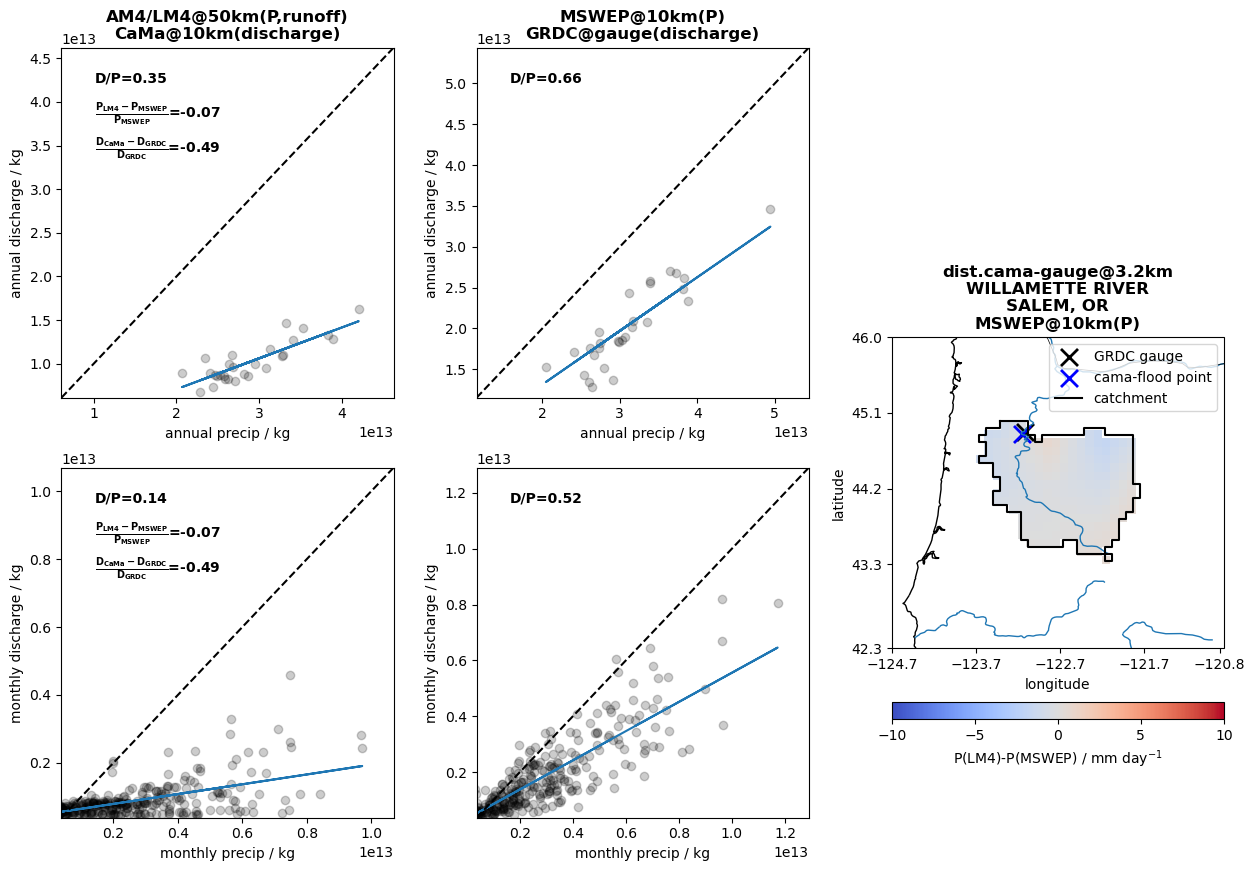

In [9]:
for i, basin in list(region.iterrows())[:3]:
    print(f"{i}\t{basin.river}")
    grdc_basin = grdc.sel(id=basin.grdc_no)
    basin_scale = np.sqrt(grdc_basin.area.values)
    if (basin_scale < 100):
        print(f"Basin scale too small (~{np.round(basin_scale, 2)} km) for comparison to model.")
        continue
    elif (basin_scale > 500): 
        print(f"Basin scale too large (~{np.round(basin_scale, 2)} km) for now...")
        continue
    basin_ext_xx, basin_ext_yy = basin.geometry.exterior.coords.xy
    basin_ext_xx = np.array(basin_ext_xx)
    basin_ext_yy = np.array(basin_ext_yy)
    model_basin_data = model_data.sel(
        {
            'lon': slice(basin_ext_xx.min()-1, basin_ext_xx.max()+1),
            'lat': slice(basin_ext_yy.min()-1, basin_ext_yy.max()+1)
        })
    cama_basin_data = cama_data_reverse_lat.sel(
        {
            'lon': slice(basin_ext_xx.min()-1, basin_ext_xx.max()+1),
            'lat': slice(basin_ext_yy.min()-1, basin_ext_yy.max()+1)
        })
    mswep_basin_data = era5_data.sel(
        {
            'lon': slice(basin_ext_xx.min()-1, basin_ext_xx.max()+1),
            'lat': slice(basin_ext_yy.min()-1, basin_ext_yy.max()+1)
        })
    model_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in model_basin_data.lon] 
                    for lat in model_basin_data.lat]).squeeze(),
        coords=(model_basin_data.lat, model_basin_data.lon)
        )
    cama_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in cama_basin_data.lon] 
                    for lat in cama_basin_data.lat]).squeeze(),
        coords=(cama_basin_data.lat, cama_basin_data.lon)
        )
    # mswep_basin_mask = xr.DataArray(
    #     data=np.array([[basin.geometry.contains(Point(lon, lat)) 
    #                     for lon in mswep_basin_data.lon] 
    #                 for lat in mswep_basin_data.lat]).squeeze(),
    #     coords=(mswep_basin_data.lat, mswep_basin_data.lon)
    #     )
    mswep_precip = mswep_basin_data.pr.sel(time=slice('1980','2007'))
    model_precip = model_basin_data.pr.sel(time=slice('1980','2007'))
    # Interpolate precip to 10 km cama grid
    print("Interpolating precip data...")
    mswep_precip = mswep_precip.interp({'lat': cama_basin_data.lat, 'lon': cama_basin_data.lon})
    model_precip = model_precip.interp({'lat': cama_basin_data.lat, 'lon': cama_basin_data.lon})
    # Mask precip data to reduce to precip in basin
    model_precip = model_precip.where(cama_basin_mask)
    mswep_precip = mswep_precip.where(cama_basin_mask)

    # Take discharge at point closest to gauge (transform to kg s^-1)
    cama_dsch = (cama_data.outflw * 1000 ).sel(time=slice('1980','2007'))
    basin_gauge_in_cama_alloc = np.isin(grdc_alloc.index, int(basin.grdc_no))
    if not basin_gauge_in_cama_alloc.any():
        print("Basin Gauge could not be allocated to CaMa-Flood pixel. Continuing...")
        continue
    cama_dsch = grdcu.get_closest_cama_point_to_gauge(cama_dsch, grdc_alloc.loc[basin_gauge_in_cama_alloc])
    nearest_cama_lat = cama_dsch.lat.values
    nearest_cama_lon = cama_dsch.lon.values
    cama_dsch = cama_dsch.sum(['lat', 'lon'])
    # Store coordinate of nearest point
    nearest_cama_lat, nearest_cama_lon = grdcu.find_nearest_point(
        cama_data.lat.values, cama_data.lon.values, basin.lat_org, basin.long_org)
    dist_cama_gauge = grdcu.haversine(nearest_cama_lon, nearest_cama_lat, basin.long_org, basin.lat_org)
    obs_dsch = grdc_basin.runoff_mean.sel(time=slice('1980','2007'))*1000 # obs discharge from gauge, kg s^-1
    # Spatially integrate precipitation
    model_pixel_area = grdcu.calculate_grid_area(model_precip.lon.values, model_precip.lat.values)
    mswep_pixel_area = grdcu.calculate_grid_area(mswep_precip.lon.values, mswep_precip.lat.values)
    model_basin_precip_sum = (model_pixel_area * model_precip).sum(['lat', 'lon'])
    mswep_basin_precip_sum = (mswep_pixel_area * mswep_precip).sum(['lat', 'lon'])
    # Get annual integrals
    model_basin_precip_sum_annual = (model_basin_precip_sum*86400).groupby('time.year').sum('time')
    mswep_basin_precip_sum_annual = (mswep_basin_precip_sum*86400).groupby('time.year').sum('time')
    cama_dsch_annual = (cama_dsch*86400).groupby('time.year').sum('time')
    obs_dsch_annual = (obs_dsch*86400).groupby('time.year').sum('time')
    # Get monthly integrals
    model_basin_precip_sum_monthly = (model_basin_precip_sum*86400).resample({'time': '1m'}).sum('time')
    mswep_basin_precip_sum_monthly = (mswep_basin_precip_sum*86400).resample({'time': '1m'}).sum('time')
    cama_dsch_monthly = (cama_dsch*86400).resample({'time': '1m'}).sum('time')
    obs_dsch_monthly = (obs_dsch*86400).resample({'time': '1m'}).sum('time')
    
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(
        nrows=2, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1], hspace=0.2, wspace=0.25)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(model_basin_precip_sum_annual, cama_dsch_annual, color='k', alpha=0.2)
    m_model_annual, c = grdcu.get_lin_reg_coefs(model_basin_precip_sum_annual, cama_dsch_annual)
    ax1.plot(model_basin_precip_sum_annual, model_basin_precip_sum_annual*m_model_annual+c)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(mswep_basin_precip_sum_annual, obs_dsch_annual, color='k', alpha=0.2)
    m_obs_annual, c = grdcu.get_lin_reg_coefs(mswep_basin_precip_sum_annual, obs_dsch_annual)
    ax2.plot(mswep_basin_precip_sum_annual, mswep_basin_precip_sum_annual*m_obs_annual+c)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(model_basin_precip_sum_monthly, cama_dsch_monthly, color='k', alpha=0.2)
    m_model_monthly, c = grdcu.get_lin_reg_coefs(model_basin_precip_sum_monthly, cama_dsch_monthly)
    ax3.plot(model_basin_precip_sum_monthly, model_basin_precip_sum_monthly*m_model_monthly+c) 
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.scatter(mswep_basin_precip_sum_monthly, obs_dsch_monthly, color='k', alpha=0.2)
    m_obs_monthly, c = grdcu.get_lin_reg_coefs(mswep_basin_precip_sum_monthly, obs_dsch_monthly)
    ax4.plot(mswep_basin_precip_sum_monthly, mswep_basin_precip_sum_monthly*m_obs_monthly+c)
    ax5 = fig.add_subplot(gs[:, 2], projection=ccrs.PlateCarree())
    pc = ax5.pcolormesh(
        mswep_precip.lon, mswep_precip.lat, model_precip.mean('time')*86400 - mswep_precip.mean('time')*86400,
        cmap='coolwarm', vmin=-10, vmax=10
    )
    fig.colorbar(
        pc, ax=ax5, orientation='horizontal', pad=0.07,
        label='P(LM4)-P(MSWEP) / mm day$^{-1}$')
    ax5.scatter(
        basin.long_org, basin.lat_org,
        color='black', marker='x', s=150, label='GRDC gauge', lw=2,
    )
    ax5.scatter(
        nearest_cama_lon, nearest_cama_lat,
        color='blue', marker='x', s=150, label='cama-flood point', lw=2,
    )
    xx, yy = basin.geometry.exterior.coords.xy
    ax5.plot(xx, yy, color='black', lw=1.5, label='catchment')
    ax1.set(xlim=[
        cama_dsch_annual.min()-cama_dsch_annual.min()*0.1,
        model_basin_precip_sum_annual.max()+model_basin_precip_sum_annual.max()*0.1],
            ylim=[
        cama_dsch_annual.min()-cama_dsch_annual.min()*0.1,
        model_basin_precip_sum_annual.max()+model_basin_precip_sum_annual.max()*0.1,
            ],
            xlabel='annual precip / kg', ylabel='annual discharge / kg')
    ax1.set_title('AM4/LM4@50km(P,runoff)\nCaMa@10km(discharge)', weight='bold')
    ax2.set(xlim=[
        obs_dsch_annual.min()-obs_dsch_annual.min()*0.1,
        mswep_basin_precip_sum_annual.max()+mswep_basin_precip_sum_annual.max()*0.1],
            ylim=[
        obs_dsch_annual.min()-obs_dsch_annual.min()*0.1,
        mswep_basin_precip_sum_annual.max()+mswep_basin_precip_sum_annual.max()*0.1,
            ],
            xlabel='annual precip / kg', ylabel='annual discharge / kg')
    ax2.set_title('MSWEP@10km(P)\nGRDC@gauge(discharge)', weight='bold')
    ax3.set(xlim=[
        cama_dsch_monthly.min()-cama_dsch_monthly.min()*0.1,
        model_basin_precip_sum_monthly.max()+model_basin_precip_sum_monthly.max()*0.1],
            ylim=[
        cama_dsch_monthly.min()-cama_dsch_monthly.min()*0.1,
        model_basin_precip_sum_monthly.max()+model_basin_precip_sum_monthly.max()*0.1,
            ],
            xlabel='monthly precip / kg', ylabel='monthly discharge / kg')
    ax4.set(xlim=[
        obs_dsch_monthly.min()-obs_dsch_monthly.min()*0.1,
        mswep_basin_precip_sum_monthly.max()+mswep_basin_precip_sum_monthly.max()*0.1],
            ylim=[
        obs_dsch_monthly.min()-obs_dsch_monthly.min()*0.1,
        mswep_basin_precip_sum_monthly.max()+mswep_basin_precip_sum_monthly.max()*0.1,
            ],
            xlabel='monthly precip / kg', ylabel='monthly discharge / kg')
    for ax in [ax1, ax2, ax3, ax4]:
        ax.axline(xy1=(0, 0), slope=1, color='k', ls='--')
    edge = 1
    ax5.set_extent(
        [np.min(basin_ext_xx)-edge, np.max(basin_ext_xx)+edge, 
         np.min(basin_ext_yy)-edge, np.max(basin_ext_yy)+edge], 
        crs=ccrs.PlateCarree())
    ax5.coastlines("10m", linewidth=1)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    ax5.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=1)
    ax5.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax5.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    ax5.set_xticks(
        np.round(
            np.linspace(
                np.min(basin_ext_xx)-edge, 
                np.max(basin_ext_xx)+edge, 
                5), 
            1), 
        crs=ccrs.PlateCarree())
    ax5.set_yticks(
        np.round(
            np.linspace(
                np.min(basin_ext_yy)-edge, 
                np.max(basin_ext_yy)+edge, 
                5), 
            1), 
        crs=ccrs.PlateCarree())
    ax5.set(xlabel='longitude', ylabel='latitude')
    ax5.set_title(f'dist.cama-gauge@{np.round(dist_cama_gauge/1000, 1)}km\n{basin.river}\n{basin.station}\nMSWEP@10km(P)', weight='bold')
    ax5.legend()
    ax1.text(0.1, 0.9, f'D/P={np.round(m_model_annual, 2)}', transform=ax1.transAxes, weight='bold')
    ax1.text(
        0.1, 0.8, 
        r'$\mathbf{\frac{P_{LM4}-P_{MSWEP}}{P_{MSWEP}}}$='+
        f'{np.round((model_basin_precip_sum_annual.mean()-mswep_basin_precip_sum_annual.mean())/mswep_basin_precip_sum_annual.mean(), 2).values}',
        transform=ax1.transAxes, weight='bold')
    ax1.text(
        0.1, 0.7, 
        r'$\mathbf{\frac{D_{CaMa}-D_{GRDC}}{D_{GRDC}}}$='+
        f'{np.round((cama_dsch_annual.mean()-obs_dsch_annual.mean())/obs_dsch_annual.mean(), 2).values}',
        transform=ax1.transAxes, weight='bold')
    ax2.text(0.1, 0.9, f'D/P={np.round(m_obs_annual, 2)}', transform=ax2.transAxes, weight='bold')
    ax3.text(0.1, 0.9, f'D/P={np.round(m_model_monthly, 2)}', transform=ax3.transAxes, weight='bold')
    ax3.text(
        0.1, 0.8, 
        r'$\mathbf{\frac{P_{LM4}-P_{MSWEP}}{P_{MSWEP}}}$='+
        f'{np.round((model_basin_precip_sum_monthly.mean()-mswep_basin_precip_sum_monthly.mean())/mswep_basin_precip_sum_monthly.mean(), 2).values}',
        transform=ax3.transAxes, weight='bold')
    ax3.text(
        0.1, 0.7, 
        r'$\mathbf{\frac{D_{CaMa}-D_{GRDC}}{D_{GRDC}}}$='+
        f'{np.round((cama_dsch_monthly.mean()-obs_dsch_monthly.mean())/obs_dsch_monthly.mean(), 2).values}',
        transform=ax3.transAxes, weight='bold')
    ax4.text(0.1, 0.9, f'D/P={np.round(m_obs_monthly, 2)}', transform=ax4.transAxes, weight='bold')

## Compare catchment scale maps of precip and discharge between model and obs

4115201.0	COLUMBIA RIVER
Interpolating precip data...
4115200.0	COLUMBIA RIVER
Overlapping with prior basin, skipping this one...
4116182.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4115202.0	COLUMBIA RIVER
Overlapping with prior basin, skipping this one...
4116181.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4115205.0	COLUMBIA RIVER
Overlapping with prior basin, skipping this one...
4115206.0	COLUMBIA RIVER
Overlapping with prior basin, skipping this one...
4116183.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4116184.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4215210.0	COLUMBIA RIVER
Overlapping with prior basin, skipping this one...
4116185.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4116186.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4116187.0	SNAKE RIVER
Overlapping with prior basin, skipping this one...
4215200.0	COLUMBIA RIVER
Overlapping with prior basin, 

/tmp/ipykernel_53316/3610030957.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


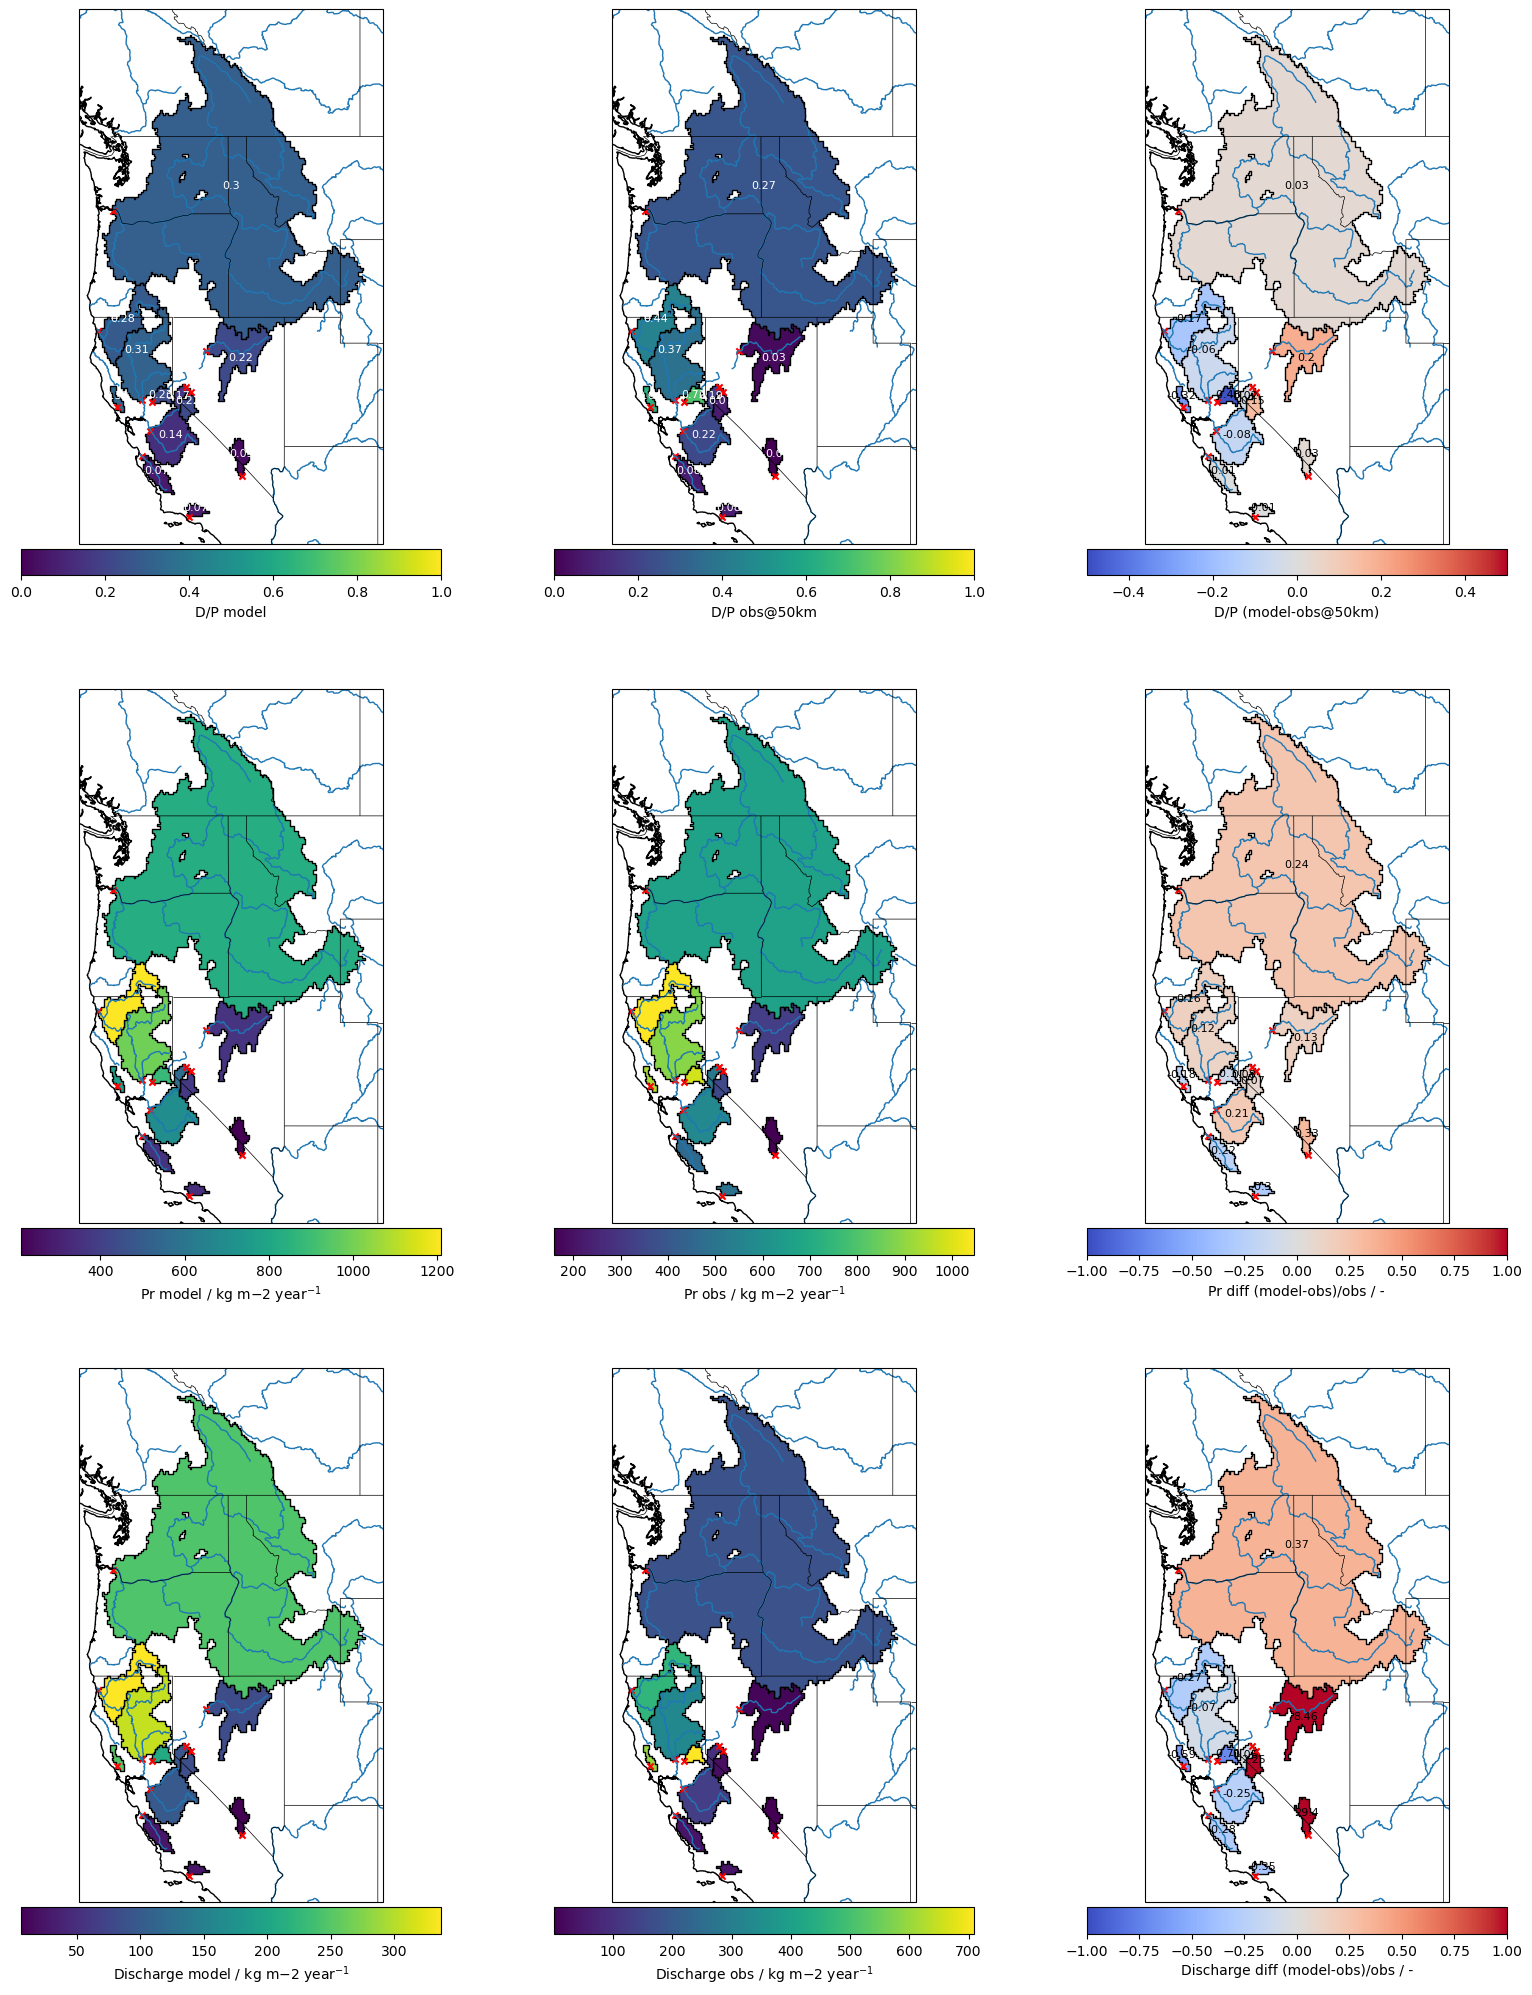

In [16]:
fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(
    nrows=3, ncols=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
ax8 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
ax9 = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree())
region4plot = region.sort_values('area', ascending=False).set_index('grdc_no')
region4plot['pr_model'] = np.nan * np.ones((len(region4plot)))
region4plot['pr_obs'] = np.nan * np.ones((len(region4plot)))
region4plot['pr_diff_model_obs'] = np.nan * np.ones((len(region4plot)))
region4plot['dc_model'] = np.nan * np.ones((len(region4plot)))
region4plot['dc_obs'] = np.nan * np.ones((len(region4plot)))
region4plot['dc_diff_model_obs'] = np.nan * np.ones((len(region4plot)))
region4plot['ro_ratio_model'] = np.nan * np.ones((len(region4plot)))
region4plot['ro_ratio_obs'] = np.nan * np.ones((len(region4plot)))
region4plot['ro_ratio_diff_model_obs'] = np.nan * np.ones((len(region4plot)))

basin_ext_xx_min = 360
basin_ext_xx_max = -180
basin_ext_yy_min = 360
basin_ext_yy_max = -180

for grdc_no, basin in list(region4plot.iterrows()):
    print(f"{grdc_no}\t{basin.river}")
    grdc_basin = grdc.sel(id=int(grdc_no))
    basin_scale = np.sqrt(grdc_basin.area.values)
    if (basin_scale < 50):
        print(f"Basin scale too small (~{np.round(basin_scale, 2)} km) for comparison to model.")
        region4plot = region4plot.drop(grdc_no)
        continue
    # elif (basin_scale > 500): 
    #     print(f"Basin scale too large (~{np.round(basin_scale, 2)} km) for now...")
    #     continue
    basin_gauge_in_cama_alloc = np.isin(grdc_alloc.index, int(grdc_no))
    if not basin_gauge_in_cama_alloc.any():
        print("Basin Gauge could not be allocated to CaMa-Flood pixel. Continuing...")
        region4plot = region4plot.drop(grdc_no)
        continue
    overlap_with_prior_basins = np.array([
        (contains(prior_basin_geometry, basin.geometry) & ~contains(basin.geometry, prior_basin_geometry) )
        for prior_basin_geometry in region4plot.loc[:grdc_no].geometry])
    if overlap_with_prior_basins.any():
       print(f"Overlapping with prior basin, skipping this one...")
       region4plot = region4plot.drop(grdc_no)
       continue
    basin_ext_xx, basin_ext_yy = basin.geometry.exterior.coords.xy
    basin_ext_xx = np.array(basin_ext_xx)
    basin_ext_yy = np.array(basin_ext_yy)
    basin_ext_xx_min = np.min([basin_ext_xx.min(), basin_ext_xx_min])
    basin_ext_xx_max = np.max([basin_ext_xx.max(), basin_ext_xx_max])
    basin_ext_yy_min = np.min([basin_ext_yy.min(), basin_ext_yy_min])
    basin_ext_yy_max = np.max([basin_ext_yy.max(), basin_ext_yy_max])
    model_basin_data = model_data.sel(
        {
            'lon': slice(basin_ext_xx.min()-1, basin_ext_xx.max()+1),
            'lat': slice(basin_ext_yy.min()-1, basin_ext_yy.max()+1)
        })
    cama_basin_data = cama_data_reverse_lat.sel(
        {
            'lon': slice(basin_ext_xx.min()-1, basin_ext_xx.max()+1),
            'lat': slice(basin_ext_yy.min()-1, basin_ext_yy.max()+1)
        })
    mswep_basin_data = era5_data.sel(
        {
            'lon': slice(basin_ext_xx.min()-1, basin_ext_xx.max()+1),
            'lat': slice(basin_ext_yy.min()-1, basin_ext_yy.max()+1)
        })
    model_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in model_basin_data.lon] 
                    for lat in model_basin_data.lat]).squeeze(),
        coords=(model_basin_data.lat, model_basin_data.lon)
        )
    cama_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in cama_basin_data.lon] 
                    for lat in cama_basin_data.lat]).squeeze(),
        coords=(cama_basin_data.lat, cama_basin_data.lon)
        )
    mswep_basin_mask = xr.DataArray(
        data=np.array([[basin.geometry.contains(Point(lon, lat)) 
                        for lon in mswep_basin_data.lon] 
                    for lat in mswep_basin_data.lat]).squeeze(),
        coords=(mswep_basin_data.lat, mswep_basin_data.lon)
        )
    mswep_precip = mswep_basin_data.pr.sel(time=slice('1980','2007'))
    model_precip = model_basin_data.pr.sel(time=slice('1980','2007'))
    # Interpolate precip to 10 km cama grid
    print("Interpolating precip data...")
    mswep_precip = mswep_precip.interp({'lat': cama_basin_data.lat, 'lon': cama_basin_data.lon})
    model_precip = model_precip.interp({'lat': cama_basin_data.lat, 'lon': cama_basin_data.lon})
    # Mask precip data to reduce to precip in basin
    model_precip = model_precip.where(cama_basin_mask)
    mswep_precip = mswep_precip.where(cama_basin_mask)

    # Take discharge at point closest to gauge (transform to kg s^-1)
    cama_dsch = (cama_data.outflw * 1000 ).sel(time=slice('1980','2007'))
    
    cama_dsch = grdcu.get_closest_cama_point_to_gauge(cama_dsch, grdc_alloc.loc[basin_gauge_in_cama_alloc])
    nearest_cama_lat = cama_dsch.lat.values
    nearest_cama_lon = cama_dsch.lon.values
    cama_dsch = cama_dsch.sum(['lat', 'lon'])
    # Store coordinate of nearest point
    nearest_cama_lat, nearest_cama_lon = grdcu.find_nearest_point(
        cama_data.lat.values, cama_data.lon.values, basin.lat_org, basin.long_org)
    dist_cama_gauge = grdcu.haversine(nearest_cama_lon, nearest_cama_lat, basin.long_org, basin.lat_org)
    obs_dsch = grdc_basin.runoff_mean.sel(time=slice('1980','2007'))*1000 # obs discharge from gauge, kg s^-1
    # Spatially integrate precipitation
    model_pixel_area = grdcu.calculate_grid_area(model_precip.lon.values, model_precip.lat.values)
    mswep_pixel_area = grdcu.calculate_grid_area(mswep_precip.lon.values, mswep_precip.lat.values)
    model_basin_precip_sum = (model_pixel_area * model_precip).sum(['lat', 'lon'])
    mswep_basin_precip_sum = (mswep_pixel_area * mswep_precip).sum(['lat', 'lon'])
    # Get annual integrals
    model_basin_precip_sum_annual = (model_basin_precip_sum*86400).groupby('time.year').sum('time')
    mswep_basin_precip_sum_annual = (mswep_basin_precip_sum*86400).groupby('time.year').sum('time')
    cama_dsch_annual = (cama_dsch*86400).groupby('time.year').sum('time')
    obs_dsch_annual = (obs_dsch*86400).groupby('time.year').sum('time')
    # Get long-term mean of integrals
    model_basin_precip_sum_annual_mean = model_basin_precip_sum_annual.mean('year')
    mswep_basin_precip_sum_annual_mean = mswep_basin_precip_sum_annual.mean('year')
    cama_dsch_annual_mean = cama_dsch_annual.mean('year')
    obs_dsch_annual_mean = obs_dsch_annual.mean('year')
    region4plot.loc[grdc_no, 'pr_model'] = model_basin_precip_sum_annual_mean / basin.area*1e-6
    region4plot.loc[grdc_no, 'pr_obs'] = mswep_basin_precip_sum_annual_mean / basin.area*1e-6
    region4plot.loc[grdc_no, 'pr_diff_model_obs'] = (
        model_basin_precip_sum_annual_mean - mswep_basin_precip_sum_annual_mean) / mswep_basin_precip_sum_annual_mean
    region4plot.loc[grdc_no, 'dc_model'] = cama_dsch_annual_mean / basin.area*1e-6
    region4plot.loc[grdc_no, 'dc_obs'] = obs_dsch_annual_mean / basin.area*1e-6
    region4plot.loc[grdc_no, 'dc_diff_model_obs'] = (
        cama_dsch_annual_mean - obs_dsch_annual_mean) / obs_dsch_annual_mean
    region4plot.loc[grdc_no, 'ro_ratio_model'] = cama_dsch_annual_mean / model_basin_precip_sum_annual_mean
    region4plot.loc[grdc_no, 'ro_ratio_obs'] = obs_dsch_annual_mean / mswep_basin_precip_sum_annual_mean
    region4plot.loc[grdc_no, 'ro_ratio_diff_model_obs'] = cama_dsch_annual_mean / model_basin_precip_sum_annual_mean - \
        obs_dsch_annual_mean / mswep_basin_precip_sum_annual_mean

caxs = [make_axes_locatable(ax).append_axes('bottom', size='5%', pad=0.05, axes_class=maxes.Axes) 
        for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]]

ax1 = region4plot.plot(column='ro_ratio_model', ax=ax1, cmap='viridis', 
                 vmin=0, vmax=1, cax=caxs[0], legend=True,
                 legend_kwds={
                     "label": "D/P model", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax2 = region4plot.plot(column='ro_ratio_obs', ax=ax2, cmap='viridis', 
                 vmin=0, vmax=1, cax=caxs[1], legend=True,
                 legend_kwds={
                     "label": "D/P obs@50km", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax3 = region4plot.plot(column='ro_ratio_diff_model_obs', ax=ax3, cmap='coolwarm', 
                 vmin=-0.5, vmax=0.5, cax=caxs[2], legend=True,
                 legend_kwds={
                     "label": "D/P (model-obs@50km)", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax4 = region4plot.plot(column='pr_model', ax=ax4, cmap='viridis', 
                 cax=caxs[3], legend=True,
                 legend_kwds={
                     "label": "Pr model / kg m${-2}$ year$^{-1}$", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax5 = region4plot.plot(column='pr_obs', ax=ax5, cmap='viridis', 
                 cax=caxs[4], legend=True,
                 legend_kwds={
                     "label": "Pr obs / kg m${-2}$ year$^{-1}$", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax6 = region4plot.plot(column='pr_diff_model_obs', ax=ax6, cmap='coolwarm', 
                 cax=caxs[5], legend=True, vmin=-1, vmax=1,
                 legend_kwds={
                     "label": "Pr diff (model-obs)/obs / -", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax7 = region4plot.plot(column='dc_model', ax=ax7, cmap='viridis', 
                 cax=caxs[6], legend=True,
                 legend_kwds={
                     "label": "Discharge model / kg m${-2}$ year$^{-1}$", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax8 = region4plot.plot(column='dc_obs', ax=ax8, cmap='viridis', 
                 cax=caxs[7], legend=True,
                 legend_kwds={
                     "label": "Discharge obs / kg m${-2}$ year$^{-1}$", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax9 = region4plot.plot(column='dc_diff_model_obs', ax=ax9, cmap='coolwarm', 
                 cax=caxs[8], legend=True, vmin=-1, vmax=1,
                 legend_kwds={
                     "label": "Discharge diff (model-obs)/obs / -", 
                     "orientation": "horizontal"},
                 edgecolor='black')
ax1 = region4plot.plot(ax=ax1, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax2 = region4plot.plot(ax=ax2, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax3 = region4plot.plot(ax=ax3, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax4 = region4plot.plot(ax=ax4, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax5 = region4plot.plot(ax=ax5, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax6 = region4plot.plot(ax=ax6, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax7 = region4plot.plot(ax=ax7, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax8 = region4plot.plot(ax=ax8, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
ax9 = region4plot.plot(ax=ax9, kind="scatter", x="long_org", y="lat_org", marker='x', color='red')
# Annotate each basin with D/P value
region4plot['coords'] = region4plot['geometry'].apply(lambda x: x.representative_point().coords[:])
region4plot['coords'] = [coords[0] for coords in region4plot['coords']]
for idx, row in region4plot.iterrows():
    ax1.annotate(text=np.round(row['ro_ratio_model'], 2), xy=row['coords'],
                 horizontalalignment='center', color='white', fontsize=8)
    ax2.annotate(text=np.round(row['ro_ratio_obs'], 2), xy=row['coords'],
                 horizontalalignment='center', color='white', fontsize=8)
    ax3.annotate(text=np.round(row['ro_ratio_diff_model_obs'], 2), xy=row['coords'],
                 horizontalalignment='center', color='black', fontsize=8)
    ax6.annotate(text=np.round(row['pr_diff_model_obs'], 2), xy=row['coords'],
                 horizontalalignment='center', color='black', fontsize=8)
    ax9.annotate(text=np.round(row['dc_diff_model_obs'], 2), xy=row['coords'],
                 horizontalalignment='center', color='black', fontsize=8)

edge = 1
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax.coastlines("10m", linewidth=1)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    ax.set_extent(
        [basin_ext_xx_min-edge, basin_ext_xx_max+edge, 
         basin_ext_yy_min-edge, basin_ext_yy_max+edge], 
        crs=ccrs.PlateCarree())
plt.tight_layout()
plt.savefig('plots/runoff_ratio_western_us_AM4_obs_50km_mswep.png', dpi=300, bbox_inches='tight')

In [43]:
contains(region4plot.geometry.iloc[0], region4plot.geometry.iloc[1])

True

In [41]:
region4plot.geometry.iloc[0]

AttributeError: 'Polygon' object has no attribute 'values'

In [28]:
np.array([overlaps(basin.geometry, prior_basin_geometry) 
                                 for prior_basin_geometry in region4plot.loc[:grdc_no].geometry])

array([False])

In [12]:
region4plot

river                               station      area  \
grdc_no                                                                         
4115201.0      COLUMBIA RIVER  BEAVER ARMY TERMINAL NEAR QUINCY, OR  665371.0   
4115200.0      COLUMBIA RIVER                        THE DALLES, OR  613830.0   
4115202.0      COLUMBIA RIVER           BELOW PRIEST RAPIDS DAM, WA  248640.0   
4115205.0      COLUMBIA RIVER                   BELOW WELLS DAM, WA  222999.0   
4115206.0      COLUMBIA RIVER                      GRAND COULEE, WA  193473.0   
4215210.0      COLUMBIA RIVER       INTERNATIONAL BOUNDARY (CANADA)  155000.0   
4215200.0      COLUMBIA RIVER                             BIRCHBANK   88100.0   
4215220.0  PEND OREILLE RIVER       INTERNATIONAL BOUNDARY (CANADA)   65300.0   
4115346.0          CLARK FORK    WHITEHORSE RAPIDS NEAR CABINET, ID   57169.1   
4115347.0          CLARK FORK                       NEAR PLAINS, MT   51691.2   

           altitude  lat_org  long_org   lat_pp   long_pp  dist_km  area_calc  \
grdc_no                                                                         
4115201.0   -999.00    46.12   -123.21  46.1812 -123.1896      0.4   651391.0   
4115200.0   -999.00    45.62   -121.21  45.6063 -121.1729      0.1   600897.0   
4115202.0    118.87    46.62   -119.87  46.6271 -119.8646      0.2   248435.0   
4115205.0    213.36    47.96   -119.87  47.9479 -119.8646      0.2   224231.0   
4115206.0    274.32    47.96   -118.96  47.9646 -118.9812      0.1   195056.0   
4215210.0    400.00    49.04   -117.62  49.0021 -117.6271      0.1   154720.0   
4215200.0    410.00    49.21   -117.71  49.1771 -117.7146      0.2    87237.0   
4215220.0   -999.00    48.96   -117.37  48.9979 -117.3521      0.1    65286.0   
4115346.0    627.89    48.12   -116.04  48.0938 -116.1188      0.3    56888.0   
4115347.0    746.49    47.37   -114.79  47.4271 -114.8562      0.3    51508.0   

          quality       type                                     comment  \
grdc_no                                                                    
4115201.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115200.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115202.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115205.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115206.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4215210.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4215200.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4215220.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115346.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115347.0    High  Automatic  Area difference <= 5% and distance <= 5 km   

               source                                           geometry  \
grdc_no                                                                    
4115201.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4115200.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4115202.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4115205.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4115206.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4215210.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4215200.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4215220.0  hydrosheds  POLYGON ((-114.83333 49.41667, -114.58333 49.4...   
4115346.0  hydrosheds  POLYGON ((-114.83333 49.41667, -114.58333 49.4...   
4115347.0  hydrosheds  POLYGON ((-114.83333 49.41667, -114.58333 49.4...   

           ro_ratio_model  ro_ratio_obs  ro_ratio_diff_model_obs  
grdc_no                                                           
4115201.0        0.296933      0.268911                 0.028022  
4115200.0        0.286235      0.441837            

In [163]:
divider = make_axes_locatable(ax1)
divider.append_axes('bottom', size='5%', pad=0.05)

<Axes: >

In [144]:
region4plot = region.sort_values('area', ascending=False).set_index('grdc_no').iloc[0:3]
region4plot['ro_ratio_model'] = np.nan * np.ones((len(region4plot)))
region4plot['ro_ratio_obs'] = np.nan * np.ones((len(region4plot)))
region4plot

river                               station      area  \
grdc_no                                                                     
4115201.0  COLUMBIA RIVER  BEAVER ARMY TERMINAL NEAR QUINCY, OR  665371.0   
4115200.0  COLUMBIA RIVER                        THE DALLES, OR  613830.0   
4115202.0  COLUMBIA RIVER           BELOW PRIEST RAPIDS DAM, WA  248640.0   

           altitude  lat_org  long_org   lat_pp   long_pp  dist_km  area_calc  \
grdc_no                                                                         
4115201.0   -999.00    46.12   -123.21  46.1812 -123.1896      0.4   651391.0   
4115200.0   -999.00    45.62   -121.21  45.6063 -121.1729      0.1   600897.0   
4115202.0    118.87    46.62   -119.87  46.6271 -119.8646      0.2   248435.0   

          quality       type                                     comment  \
grdc_no                                                                    
4115201.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115200.0    High  Automatic  Area difference <= 5% and distance <= 5 km   
4115202.0    High  Automatic  Area difference <= 5% and distance <= 5 km   

               source                                           geometry  \
grdc_no                                                                    
4115201.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4115200.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   
4115202.0  hydrosheds  POLYGON ((-119.08333 52.91667, -119.00000 52.9...   

           ro_ratio_model  ro_ratio_obs  
grdc_no                                  
4115201.0             NaN           NaN  
4115200.0             NaN           NaN  
4115202.0             NaN           NaN

grdc_no           river                      station      area  \
10  4115202.0  COLUMBIA RIVER  BELOW PRIEST RAPIDS DAM, WA  248640.0   

    altitude  lat_org  long_org   lat_pp   long_pp  dist_km  area_calc  \
10    118.87    46.62   -119.87  46.6271 -119.8646      0.2   248435.0   

   quality       type                                     comment      source  \
10    High  Automatic  Area difference <= 5% and distance <= 5 km  hydrosheds   

                                             geometry  ro_ratio_model  
10  POLYGON ((-119.08333 52.91667, -119.00000 52.9...               5

TypeError: Non geometry data passed to GeoSeries constructor, received data of dtype 'int64'

In [98]:
gpd.GeoDataFrame.assign?

Signature: gpd.GeoDataFrame.assign(self, **kwargs) -> 'DataFrame'
Docstring:
Assign new columns to a DataFrame.

Returns a new object with all original columns in addition to new ones.
Existing columns that are re-assigned will be overwritten.

Parameters
----------
**kwargs : dict of {str: callable or Series}
    The column names are keywords. If the values are
    callable, they are computed on the DataFrame and
    assigned to the new columns. The callable must not
    change input DataFrame (though pandas doesn't check it).
    If the values are not callable, (e.g. a Series, scalar, or array),
    they are simply assigned.

Returns
-------
DataFrame
    A new DataFrame with the new columns in addition to
    all the existing columns.

Notes
-----
Assigning multiple columns within the same ``assign`` is possible.
Later items in '\*\*kwargs' may refer to newly created or modified
columns in 'df'; items are computed and assigned into 'df' in order.

Examples
--------
>>> df = pd.DataF

In [58]:
np.stack([basin_ext_xx, basin_ext_yy], axis=1)

array([[-121.83333333,   44.75      ],
       [-121.16666667,   44.75      ],
       [-121.16666667,   44.66666667],
       [-121.08333333,   44.66666667],
       [-121.08333333,   44.58333333],
       [-120.83333333,   44.58333333],
       [-120.83333333,   44.5       ],
       [-120.25      ,   44.5       ],
       [-120.25      ,   44.41666667],
       [-120.        ,   44.41666667],
       [-120.        ,   44.5       ],
       [-119.91666667,   44.5       ],
       [-119.91666667,   44.41666667],
       [-119.83333333,   44.41666667],
       [-119.83333333,   44.33333333],
       [-119.66666667,   44.33333333],
       [-119.66666667,   44.08333333],
       [-119.58333333,   44.08333333],
       [-119.58333333,   44.        ],
       [-119.5       ,   44.        ],
       [-119.5       ,   43.91666667],
       [-119.75      ,   43.91666667],
       [-119.75      ,   43.75      ],
       [-119.83333333,   43.75      ],
       [-119.83333333,   43.58333333],
       [-119.91666667,   

In [50]:
from matplotlib.patches import Polygon
Polygon(np.stack([basin_ext_xx, basin_ext_yy], axis=1))


In [28]:
np.unique(cama_dsch_annual_mean)

array([1.56218758e+13,            nan])

In [49]:
sharc_base_path = '/archive/Marc.Prange/LM4p2_SHARC'
sharc_exp_name = 'clearwater_lm4sharc_ksat001_angle000_ep10_thck5m_114y'

sharc_data = ceu.load_sharc_composite_ds(
    start_year=1980, end_year=2014, base_path=sharc_base_path, exp_name=sharc_exp_name, min_precip=0, ar_str='AR_days', precip_var='pr')

model_data_comp = ceu.load_loc_composite_ds(
    start_year=1979, end_year=2014, base_path='/archive/Marc.Prange/', 
    exp_name='c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020', 
    loc_name='clearwater', min_precip=0, ar_str='AR_days')

obs_data_comp = ceu.load_loc_composite_ds(
    start_year=1980, end_year=2014, base_path='/archive/Marc.Prange/', 
    exp_name='c192_obs', 
    loc_name='clearwater', min_precip=0, ar_str='AR_days')

land_static = du.lon_360_to_180(xr.open_dataset(
    '/archive/Ming.Zhao/awg/2022.03/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/gfdl.ncrc4-intel-prod-openmp/pp/land/land.static.nc'
    )).sel({'lat': model_data_comp.lat, 'lon': model_data_comp.lon})
land_static.mrsofc.values

array(4390., dtype=float32)

In [51]:
# era5_data_nearest_ar = era5_data_nearest.isel(time=np.isin(era5_data_nearest.time, model_data_comp.strong_precip_date[:, 5]))
obs_dsch_basin_ar = obs_dsch.isel(time=np.isin(obs_dsch.time, obs_data_comp.strong_precip_date[:, 5]))
obs_dsch_basin_ar = obs_dsch_basin_ar * 1000 / model_river_static.land_area.sel({'lat': nearest_lat, 'lon': nearest_lon})

In [52]:
model_plot_params = {
    'ts': {
        'var': 'ts',
        'label': 'Ts / °C',
        'scaling': 1,
        'offset': -273.15,
        'vmin': -10,
        'vmax': 10,
        'cmap_day': 5,
        'cmap': 'coolwarm',
    },
    'mrso': {
        'var': 'mrso',
        'label': 'soil saturation / -',
        'scaling': land_static.mrsofc**-1,
        'offset': 0,
        'vmin': 0.95,
        'vmax': 1,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'mrsos': {
        'var': 'mrsos',
        'label': 'mrsos / kg m$^{-2}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 0,
        'vmax': 45,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'snow': {
        'var': 'snw',
        'label': 'snow / kg m$^{-2}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 0,
        'vmax': 100,
        'cmap_day': 5,
        'cmap': 'viridis',
    },
}

sharc_plot_params = {
    'ts': {
        'var': 't_surf',
        'label': 'Ts / °C',
        'scaling': 1,
        'offset': -273.15,
        'vmin': -10,
        'vmax': 10,
        'cmap_day': 5,
        'cmap': 'coolwarm',
    },
    'mrso': {
        'var': 'soil_liq',
        'ptid': 1,
        'zfull_soil': 0,
        'label': 'soil_liq top layer / kg m$^{-3}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 100,
        'vmax': 500,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'mrsos': {
        'var': 'soil_liq',
        'ptid': 1,
        'zfull_soil': 0,
        'label': 'soil_liq top layer / kg m$^{-3}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 100,
        'vmax': 500,
        'cmap_day': 4,
        'cmap': 'viridis',
    },
    'snow': {
        'var': 'snow',
        'ptid': 1,
        'label': 'snow / kg m$^{-2}$',
        'scaling': 1,
        'offset': 0,
        'vmin': 0,
        'vmax': 100,
        'cmap_day': 5,
        'cmap': 'viridis',
    },
}

In [77]:
def get_lin_reg_coefs(x, y): 
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

In [78]:
get_lin_reg_coefs(x=model_data_comp.pr[:, 5], y=(model_data_comp.rv_d_h2o + model_data_comp.rv_o_h2o)[:, 5])

(0.4860562631348947, 1.595289613768482e-06)

/tmp/ipykernel_1241/3020882786.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  s2 = axs[1].scatter(


[Text(0.5, 0, 'AR precip / mm day$^{-1}$'),
 Text(0, 0.5, 'discharge / mm day$^{-1}$'),
 Text(0.5, 1.0, 'LM4.2 SHARC'),
 (-5.0, 150.0),
 (-5.0, 150.0)]

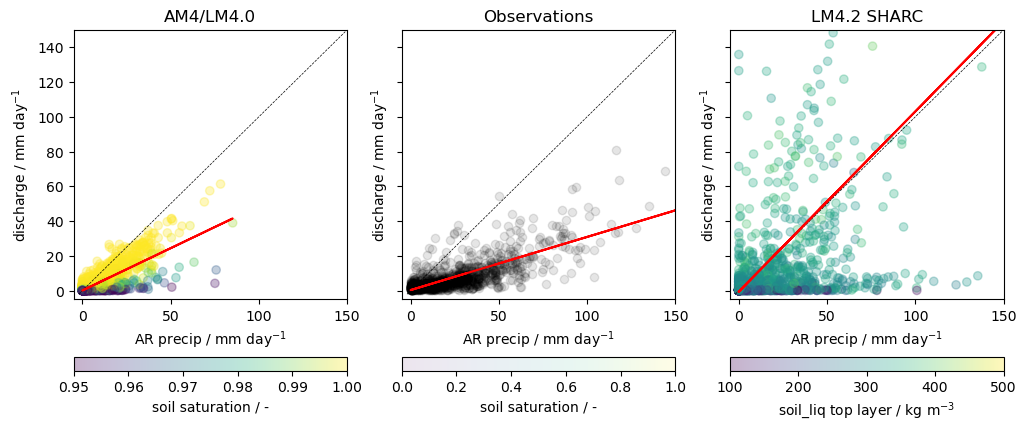

In [85]:
plot_var = 'mrso'
params = model_plot_params[plot_var]
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12, 5))
axs[0].plot(np.arange(-2, 150), np.arange(-2, 150), 'k--', lw=0.5)
s1 = axs[0].scatter(
    (model_data_comp.pr[:, 5])*86400, 
     (model_data_comp.rv_d_h2o + model_data_comp.rv_o_h2o)[:, 5]*86400,
    c=(model_data_comp[params["var"]][:, params["cmap_day"]] + params["offset"]) * params["scaling"],
    alpha=0.3, vmin=params["vmin"], vmax=params["vmax"], cmap=params["cmap"])
a, b = get_lin_reg_coefs(x=model_data_comp.pr[:, 5], y=(model_data_comp.rv_d_h2o + model_data_comp.rv_o_h2o)[:, 5])
axs[0].plot(model_data_comp.pr[:, 5]*86400, (a*model_data_comp.pr[:, 5] + b)*86400, 'r', label='Fitted line')
plt.colorbar(s1, orientation='horizontal', label=params["label"])
# Obs
axs[1].plot(np.arange(-2, 150), np.arange(-2, 150), 'k--', lw=0.5)
s2 = axs[1].scatter(
    (obs_data_comp.pr[:, 5])*86400, 
     obs_dsch_basin_ar*86400,
    c='black',
    alpha=0.1, vmin=params["vmin"], vmax=params["vmax"], cmap=params["cmap"])
a, b = get_lin_reg_coefs(x=obs_data_comp.pr[:, 5], y=obs_dsch_basin_ar)
axs[1].plot(obs_data_comp.pr[:, 5]*86400, (a*obs_data_comp.pr[:, 5] + b)*86400, 'r', label='Fitted line')
plt.colorbar(s2, orientation='horizontal', label=params['label'])
# SHARC
axs[2].plot(np.arange(-2, 150), np.arange(-2, 150), 'k--', lw=0.5)
params = sharc_plot_params[plot_var]
plot_data = sharc_data[params['var']].isel(time=params['cmap_day'])
if 'ptid' in params.keys():
    plot_data = plot_data.sel(ptid=params['ptid'])
if 'zfull_soil' in params.keys():
    plot_data = plot_data.isel(zfull_soil=params['zfull_soil'])
s3 = axs[2].scatter(
    (sharc_data.pr[:, 5]) * 86400,
    sharc_data.reach_discharge[:, 5, 0]*86400,
    c=(plot_data + params['offset']) * params['scaling'],
    alpha=0.3, vmin=params['vmin'], vmax=params['vmax'], cmap=params['cmap'])
a, b = get_lin_reg_coefs(x=sharc_data.pr[:, 5], y=sharc_data.reach_discharge[:, 5, 0])
axs[2].plot(sharc_data.pr[:, 5]*86400, (a*sharc_data.pr[:, 5] + b)*86400, 'r', label='Fitted line')
plt.colorbar(s3, orientation='horizontal', label=params['label'])
axs[0].set(
    xlabel='AR precip / mm day$^{-1}$', ylabel='discharge / mm day$^{-1}$',
    title='AM4/LM4.0')
axs[1].set(
    xlabel='AR precip / mm day$^{-1}$', ylabel='discharge / mm day$^{-1}$',
    title='Observations')
axs[2].set(
    # xlim=[-10, 100], ylim=[-10, 100], 
    xlabel='AR precip / mm day$^{-1}$', ylabel='discharge / mm day$^{-1}$',
    title='LM4.2 SHARC',
    xlim=[-5, 150], ylim=[-5, 150])
# plt.savefig(
#     f'plots/runoff/providence_scatter_20mm_events_prli_runoff_{plot_var}_LM4_p2K_SHARC.png', 
#     dpi=300, bbox_inches='tight')

In [26]:
((model_data_comp.rv_d_h2o[:, 5] + model_data_comp.rv_o_h2o[:, 5]).mean('case')*86400).values

array(5.4793356)

In [29]:
(((model_data_comp.rv_d_h2o[:, 5] + model_data_comp.rv_o_h2o[:, 5]).mean('case')*86400).values 
 - obs_dsch_basin_ar.mean('time').values*86400)/(obs_dsch_basin_ar.mean('time').values*86400)

-0.291746834159372

In [31]:
((model_data_comp.pr[:, 5]).mean('case')*86400 - (obs_data_comp.pr[:, 5]).mean('case')*86400)/((obs_data_comp.pr[:, 5]).mean('case')*86400)

<xarray.DataArray 'pr' ()>
array(-0.54436731)
Coordinates:
    lat      float64 47.75
    time     timedelta64[ns] 00:00:00
    lon      float64 ...

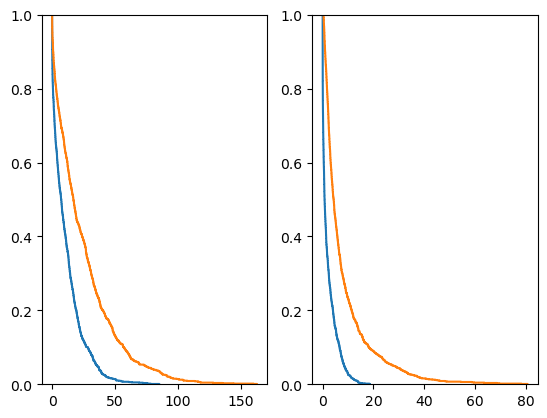

In [151]:
fig, axs = plt.subplots(ncols=2)
axs[0].ecdf(model_data_comp.pr[:, 5]*86400, complementary=True)
axs[0].ecdf(obs_data_comp.pr[:, 5]*86400, complementary=True)
axs[1].ecdf(model_data_comp.rv_o_h2o[:, 5]*86400, complementary=True)
axs[1].ecdf(obs_dsch_basin_ar*86400, complementary=True)

In [155]:
obs_dsch_basin_ar

<xarray.DataArray (time: 1128)>
array([3.1353967e-04, 7.9831916e-05, 9.7679607e-05, ..., 4.3654436e-05,
       4.7392707e-04, 7.8264296e-05], dtype=float32)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-12 1980-02-01 ... 2014-12-19
    id             int32 4146185
    lat            float64 47.75
    lon            float64 -124.1
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [156]:
(model_data_comp.rv_o_h2o[:, 5].mean('case') - obs_dsch_basin_ar.mean('time')) / obs_dsch_basin_ar.mean('time')

<xarray.DataArray ()>
array(-0.71983874, dtype=float32)
Coordinates:
    lat            float64 47.75
    lon            float64 -124.1
    time           timedelta64[ns] 00:00:00
    id             int32 4146185
    dist_to_gauge  float64 30.27
    dist           object (47.75, -124.06249999999997)

In [154]:
(model_data_comp.pr[:, 5].mean('case') - obs_data_comp.pr[:, 5].mean('case'))/obs_data_comp.pr[:, 5].mean('case')

<xarray.DataArray 'pr' ()>
array(-0.54436731)
Coordinates:
    lat      float64 47.75
    time     timedelta64[ns] 00:00:00
    lon      float64 ...